In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import os

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [5]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(12, activation=tf.keras.activations.get('softmax')))
    
    return model

In [6]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3];
            u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6];
            u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9];
            u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        u_x_4 = g.gradient(u4, self.Xr_tf)/self.sigma_x
        u_x_5 = g.gradient(u5, self.Xr_tf)/self.sigma_x
        u_x_6 = g.gradient(u6, self.Xr_tf)/self.sigma_x
        u_x_7 = g.gradient(u7, self.Xr_tf)/self.sigma_x
        u_x_8 = g.gradient(u8, self.Xr_tf)/self.sigma_x
        u_x_9 = g.gradient(u9, self.Xr_tf)/self.sigma_x
        u_x_10 = g.gradient(u10, self.Xr_tf)/self.sigma_x
        u_x_11 = g.gradient(u11, self.Xr_tf)/self.sigma_x
        u_x_12 = g.gradient(u12, self.Xr_tf)/self.sigma_x
        
        
        #-----------------------------------------------
        # specify transition rate
        #for the element 1
        Lambda2_1_1=7; Mu1_2_1=100;
        #for the element 2
        Lambda2_1_2=10; Mu1_2_2=80;
        #for the element 3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        # calcualte ode terms
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu2_3_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12
        #-----------------------------------------------
        
        # calculate residuals
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))+tf.reduce_mean(tf.square(residual_4))+\
        tf.reduce_mean(tf.square(residual_5))+tf.reduce_mean(tf.square(residual_6))+\
        tf.reduce_mean(tf.square(residual_7))+tf.reduce_mean(tf.square(residual_8))+\
        tf.reduce_mean(tf.square(residual_9))+tf.reduce_mean(tf.square(residual_10))+\
        tf.reduce_mean(tf.square(residual_11))+tf.reduce_mean(tf.square(residual_12))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1)); loss_2 = tf.reduce_mean(tf.square(residual_2));
        loss_3 = tf.reduce_mean(tf.square(residual_3)); loss_4 = tf.reduce_mean(tf.square(residual_4)); 
        loss_5 = tf.reduce_mean(tf.square(residual_5)); loss_6 = tf.reduce_mean(tf.square(residual_6));
        loss_7 = tf.reduce_mean(tf.square(residual_7)); loss_8 = tf.reduce_mean(tf.square(residual_8));
        loss_9 = tf.reduce_mean(tf.square(residual_9)); loss_10 = tf.reduce_mean(tf.square(residual_10));
        loss_11 = tf.reduce_mean(tf.square(residual_11)); loss_12 = tf.reduce_mean(tf.square(residual_12))
        
        del g
        
        return loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_9, loss_10, loss_11, loss_12
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_9, loss_10, loss_11, loss_12 = self.get_r()
        
        return [loss_u, loss_1 + loss_2 + loss_3 + loss_4 +loss_5+loss_6+loss_7+loss_8+loss_9+loss_10+loss_11+loss_12]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])

### Generate training data

In [7]:
######################################################################################
# Number of training data
N_u = 1                       # Boundary condition data on u(x)  
N_r = 500                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([0.2])         # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])   # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [8]:
N = 40000

### Train PINN without PCGrad

In [9]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [10]:
try:
    PINN_solver.model.load_weights('./checkpoints/pinn_solver')
except:
    optim = tf.keras.optimizers.Adam(epsilon=1e-30)
    PINN_solver.train(N=N, optimizer=optim, method = 'original')
    
    PINN_solver.model.save_weights('./checkpoints/pinn_solver')

Iteration 00000: loss = 0.08280759,1988.7423
Iteration 00005: loss = 0.08258636,1754.5768
Iteration 00010: loss = 0.083634295,1622.6858
Iteration 00015: loss = 0.085566424,1515.6445
Iteration 00020: loss = 0.0874824,1395.9902
Iteration 00025: loss = 0.08887321,1274.0547
Iteration 00030: loss = 0.08972776,1180.1196
Iteration 00035: loss = 0.09021867,1112.925
Iteration 00040: loss = 0.09050992,1049.0425
Iteration 00045: loss = 0.09073472,980.5673
Iteration 00050: loss = 0.09097772,915.75635
Iteration 00055: loss = 0.09113699,855.6688
Iteration 00060: loss = 0.09097588,790.42395
Iteration 00065: loss = 0.090209015,716.2355
Iteration 00070: loss = 0.088424705,627.90393
Iteration 00075: loss = 0.084477104,514.2722
Iteration 00080: loss = 0.07523332,365.57
Iteration 00085: loss = 0.055081908,194.42862
Iteration 00090: loss = 0.027529182,79.035736
Iteration 00095: loss = 0.012343578,58.09111
Iteration 00100: loss = 0.009091509,48.657715
Iteration 00105: loss = 0.0103438,31.635973
Iteration 00

Iteration 00900: loss = 0.0070338566,0.2321458
Iteration 00905: loss = 0.007029207,0.2291116
Iteration 00910: loss = 0.0070246006,0.22613786
Iteration 00915: loss = 0.0070200334,0.22322476
Iteration 00920: loss = 0.0070155077,0.22036868
Iteration 00925: loss = 0.007011013,0.21756995
Iteration 00930: loss = 0.0070065595,0.21482655
Iteration 00935: loss = 0.0070021567,0.21213819
Iteration 00940: loss = 0.0069977897,0.20950234
Iteration 00945: loss = 0.006993459,0.20691907
Iteration 00950: loss = 0.006989177,0.20438632
Iteration 00955: loss = 0.0069849286,0.20190361
Iteration 00960: loss = 0.006980714,0.19946964
Iteration 00965: loss = 0.006976562,0.19708295
Iteration 00970: loss = 0.006972441,0.19474319
Iteration 00975: loss = 0.0069683655,0.19244888
Iteration 00980: loss = 0.006964321,0.19019827
Iteration 00985: loss = 0.006960314,0.18799137
Iteration 00990: loss = 0.0069563636,0.18582669
Iteration 00995: loss = 0.0069524446,0.1837036
Iteration 01000: loss = 0.006948577,0.18162042
Itera

Iteration 01780: loss = 0.00666172,0.055280745
Iteration 01785: loss = 0.006660832,0.0549715
Iteration 01790: loss = 0.0066599525,0.054664936
Iteration 01795: loss = 0.006659076,0.054360982
Iteration 01800: loss = 0.006658202,0.054059416
Iteration 01805: loss = 0.0066573345,0.053760424
Iteration 01810: loss = 0.006656473,0.053463794
Iteration 01815: loss = 0.0066556227,0.05316966
Iteration 01820: loss = 0.0066547696,0.052877862
Iteration 01825: loss = 0.006653925,0.05258853
Iteration 01830: loss = 0.0066530644,0.05230145
Iteration 01835: loss = 0.00665224,0.05201672
Iteration 01840: loss = 0.006651407,0.05173439
Iteration 01845: loss = 0.0066505834,0.051454194
Iteration 01850: loss = 0.006649746,0.05117632
Iteration 01855: loss = 0.0066489354,0.050900586
Iteration 01860: loss = 0.0066481195,0.05062709
Iteration 01865: loss = 0.0066473014,0.05035575
Iteration 01870: loss = 0.006646503,0.050086573
Iteration 01875: loss = 0.006645687,0.0498195
Iteration 01880: loss = 0.006644892,0.0495545

Iteration 02635: loss = 0.0065583284,0.024764106
Iteration 02640: loss = 0.0065579135,0.0246632
Iteration 02645: loss = 0.006557506,0.024562892
Iteration 02650: loss = 0.00655709,0.024463069
Iteration 02655: loss = 0.006556677,0.02436374
Iteration 02660: loss = 0.0065562613,0.024264963
Iteration 02665: loss = 0.0065558474,0.02416663
Iteration 02670: loss = 0.0065554474,0.024068926
Iteration 02675: loss = 0.0065550376,0.023971627
Iteration 02680: loss = 0.006554629,0.023874843
Iteration 02685: loss = 0.006554236,0.023778578
Iteration 02690: loss = 0.006553817,0.023682773
Iteration 02695: loss = 0.006553412,0.023587437
Iteration 02700: loss = 0.0065530245,0.02349264
Iteration 02705: loss = 0.006552608,0.023398325
Iteration 02710: loss = 0.0065522236,0.023304442
Iteration 02715: loss = 0.006551822,0.023210987
Iteration 02720: loss = 0.006551431,0.023118071
Iteration 02725: loss = 0.0065510334,0.023025589
Iteration 02730: loss = 0.006550642,0.022933653
Iteration 02735: loss = 0.006550252,0

Iteration 03495: loss = 0.0065009785,0.012878331
Iteration 03500: loss = 0.0065006916,0.012832095
Iteration 03505: loss = 0.0065004397,0.012785993
Iteration 03510: loss = 0.0065001585,0.01274013
Iteration 03515: loss = 0.0064998777,0.0126944585
Iteration 03520: loss = 0.0064996234,0.012648938
Iteration 03525: loss = 0.006499341,0.012603619
Iteration 03530: loss = 0.0064990544,0.0125585
Iteration 03535: loss = 0.0064987973,0.012513566
Iteration 03540: loss = 0.0064985272,0.012468783
Iteration 03545: loss = 0.0064982497,0.012424216
Iteration 03550: loss = 0.0064979936,0.012379797
Iteration 03555: loss = 0.0064977254,0.01233558
Iteration 03560: loss = 0.0064974427,0.012291532
Iteration 03565: loss = 0.0064971913,0.0122476565
Iteration 03570: loss = 0.00649691,0.012203926
Iteration 03575: loss = 0.0064966455,0.012160439
Iteration 03580: loss = 0.0064963843,0.012117072
Iteration 03585: loss = 0.006496094,0.012073888
Iteration 03590: loss = 0.0064958446,0.012030868
Iteration 03595: loss = 0.

Iteration 04360: loss = 0.0064591733,0.0070649497
Iteration 04365: loss = 0.006458953,0.007041275
Iteration 04370: loss = 0.006458737,0.0070177047
Iteration 04375: loss = 0.00645854,0.006994226
Iteration 04380: loss = 0.0064583346,0.006970822
Iteration 04385: loss = 0.0064581255,0.006947517
Iteration 04390: loss = 0.006457914,0.0069242856
Iteration 04395: loss = 0.006457698,0.006901169
Iteration 04400: loss = 0.0064574797,0.0068781315
Iteration 04405: loss = 0.006457265,0.006855176
Iteration 04410: loss = 0.0064570713,0.0068322625
Iteration 04415: loss = 0.0064568613,0.0068094917
Iteration 04420: loss = 0.006456649,0.006786797
Iteration 04425: loss = 0.006456431,0.006764181
Iteration 04430: loss = 0.006456221,0.0067416197
Iteration 04435: loss = 0.0064560124,0.006719144
Iteration 04440: loss = 0.0064558177,0.006696796
Iteration 04445: loss = 0.006455589,0.0066744983
Iteration 04450: loss = 0.006455396,0.0066523235
Iteration 04455: loss = 0.006455196,0.0066301534
Iteration 04460: loss =

Iteration 05205: loss = 0.006432433,0.0045931623
Iteration 05210: loss = 0.0064280084,0.004098366
Iteration 05215: loss = 0.0064249337,0.0042435033
Iteration 05220: loss = 0.006424744,0.0042325365
Iteration 05225: loss = 0.0064266417,0.004066769
Iteration 05230: loss = 0.0064282627,0.0040801764
Iteration 05235: loss = 0.006428041,0.0040648496
Iteration 05240: loss = 0.00642662,0.00402185
Iteration 05245: loss = 0.006425774,0.004023641
Iteration 05250: loss = 0.0064261667,0.0039981916
Iteration 05255: loss = 0.006426653,0.00398872
Iteration 05260: loss = 0.006426234,0.0039728554
Iteration 05265: loss = 0.0064256233,0.00396231
Iteration 05270: loss = 0.006425669,0.0039482196
Iteration 05275: loss = 0.006425798,0.0039367275
Iteration 05280: loss = 0.0064253714,0.00392389
Iteration 05285: loss = 0.006425133,0.003912219
Iteration 05290: loss = 0.006425234,0.0038999876
Iteration 05295: loss = 0.006424896,0.003887855
Iteration 05300: loss = 0.0064247637,0.0038758381
Iteration 05305: loss = 0.

Iteration 06065: loss = 0.0064076963,0.0034049358
Iteration 06070: loss = 0.006412742,0.007248851
Iteration 06075: loss = 0.0064119003,0.006668743
Iteration 06080: loss = 0.006407898,0.0037321397
Iteration 06085: loss = 0.0064033107,0.0024678293
Iteration 06090: loss = 0.006400212,0.0028896504
Iteration 06095: loss = 0.006399727,0.0030179583
Iteration 06100: loss = 0.0064012357,0.002581546
Iteration 06105: loss = 0.006403057,0.0024512128
Iteration 06110: loss = 0.006403791,0.0025414333
Iteration 06115: loss = 0.006403117,0.0024649166
Iteration 06120: loss = 0.0064019267,0.0024207896
Iteration 06125: loss = 0.006401352,0.0024384474
Iteration 06130: loss = 0.0064016604,0.002407509
Iteration 06135: loss = 0.006402107,0.0024023612
Iteration 06140: loss = 0.006401922,0.0023937426
Iteration 06145: loss = 0.0064013847,0.0023846284
Iteration 06150: loss = 0.006401246,0.0023782514
Iteration 06155: loss = 0.00640136,0.0023700846
Iteration 06160: loss = 0.006401228,0.0023634564
Iteration 06165: l

Iteration 06950: loss = 0.006383334,0.0015549334
Iteration 06955: loss = 0.0063832398,0.001550836
Iteration 06960: loss = 0.006383126,0.0015467817
Iteration 06965: loss = 0.006383035,0.0015427268
Iteration 06970: loss = 0.006382931,0.0015386919
Iteration 06975: loss = 0.0063828235,0.0015346555
Iteration 06980: loss = 0.00638272,0.0015306385
Iteration 06985: loss = 0.0063826195,0.0015266404
Iteration 06990: loss = 0.0063825217,0.001522639
Iteration 06995: loss = 0.0063824155,0.001518636
Iteration 07000: loss = 0.0063822954,0.0015146695
Iteration 07005: loss = 0.0063822116,0.001510706
Iteration 07010: loss = 0.0063821035,0.0015067309
Iteration 07015: loss = 0.0063819974,0.0015027954
Iteration 07020: loss = 0.0063818977,0.001498855
Iteration 07025: loss = 0.0063817897,0.0014948964
Iteration 07030: loss = 0.006381707,0.0014910023
Iteration 07035: loss = 0.0063815974,0.0014870743
Iteration 07040: loss = 0.006381474,0.0014831775
Iteration 07045: loss = 0.006381396,0.00147929
Iteration 07050:

Iteration 07795: loss = 0.0063672015,0.0010234214
Iteration 07800: loss = 0.0063671856,0.0010199853
Iteration 07805: loss = 0.0063671046,0.0010179275
Iteration 07810: loss = 0.00636702,0.001015001
Iteration 07815: loss = 0.00636687,0.0010127759
Iteration 07820: loss = 0.006366854,0.0010100324
Iteration 07825: loss = 0.0063667465,0.0010076077
Iteration 07830: loss = 0.0063666566,0.0010051002
Iteration 07835: loss = 0.006366575,0.0010026458
Iteration 07840: loss = 0.0063664746,0.0010001841
Iteration 07845: loss = 0.006366404,0.0009977152
Iteration 07850: loss = 0.0063663037,0.0009952874
Iteration 07855: loss = 0.0063662506,0.0009929457
Iteration 07860: loss = 0.0063661262,0.0009907719
Iteration 07865: loss = 0.006366091,0.0009883015
Iteration 07870: loss = 0.0063659344,0.0009861558
Iteration 07875: loss = 0.006365958,0.0009843191
Iteration 07880: loss = 0.0063656946,0.0009854159
Iteration 07885: loss = 0.0063659498,0.0009996223
Iteration 07890: loss = 0.006365061,0.0011040241
Iteration 0

Iteration 08635: loss = 0.0063414783,0.10361358
Iteration 08640: loss = 0.0063479412,0.021986501
Iteration 08645: loss = 0.0063547124,0.0013050288
Iteration 08650: loss = 0.006358516,0.010697648
Iteration 08655: loss = 0.0063584917,0.011588657
Iteration 08660: loss = 0.0063566244,0.0057420437
Iteration 08665: loss = 0.0063545094,0.0013708792
Iteration 08670: loss = 0.006353346,0.0008163904
Iteration 08675: loss = 0.006352329,0.001620996
Iteration 08680: loss = 0.006352106,0.0015383787
Iteration 08685: loss = 0.006352678,0.00087874994
Iteration 08690: loss = 0.006353313,0.0006879597
Iteration 08695: loss = 0.0063536535,0.000822763
Iteration 08700: loss = 0.0063534766,0.0007676471
Iteration 08705: loss = 0.006352979,0.0006743008
Iteration 08710: loss = 0.00635264,0.0006997031
Iteration 08715: loss = 0.0063526276,0.0006901404
Iteration 08720: loss = 0.006352809,0.0006689704
Iteration 08725: loss = 0.006352797,0.0006765444
Iteration 08730: loss = 0.006352632,0.00066700584
Iteration 08735: 

Iteration 09520: loss = 0.0063420944,0.0005107187
Iteration 09525: loss = 0.006342349,0.0004753
Iteration 09530: loss = 0.006342461,0.0004906366
Iteration 09535: loss = 0.0063422904,0.00047447503
Iteration 09540: loss = 0.006342076,0.00047628034
Iteration 09545: loss = 0.0063420166,0.00047275698
Iteration 09550: loss = 0.0063420585,0.0004710656
Iteration 09555: loss = 0.006341987,0.00046946292
Iteration 09560: loss = 0.0063418713,0.00046844548
Iteration 09565: loss = 0.0063418318,0.0004668787
Iteration 09570: loss = 0.0063418294,0.00046617602
Iteration 09575: loss = 0.0063417344,0.00046479504
Iteration 09580: loss = 0.00634169,0.00046385964
Iteration 09585: loss = 0.006341633,0.0004627917
Iteration 09590: loss = 0.0063415747,0.0004618057
Iteration 09595: loss = 0.006341496,0.0004608533
Iteration 09600: loss = 0.006341485,0.00045993537
Iteration 09605: loss = 0.0063413675,0.0004592767
Iteration 09610: loss = 0.0063413796,0.00045868833
Iteration 09615: loss = 0.0063411915,0.00045928563
I

Iteration 10345: loss = 0.0063329046,0.00034800396
Iteration 10350: loss = 0.006332485,0.0003552081
Iteration 10355: loss = 0.006332629,0.0003462747
Iteration 10360: loss = 0.0063330843,0.00034294138
Iteration 10365: loss = 0.0063333884,0.00034386557
Iteration 10370: loss = 0.0063333143,0.00034050638
Iteration 10375: loss = 0.0063331164,0.0003406119
Iteration 10380: loss = 0.006333033,0.00033954883
Iteration 10385: loss = 0.0063330117,0.00033863843
Iteration 10390: loss = 0.006332954,0.00033805994
Iteration 10395: loss = 0.006332909,0.00033714477
Iteration 10400: loss = 0.006332837,0.00033660082
Iteration 10405: loss = 0.0063328333,0.00033579426
Iteration 10410: loss = 0.0063326955,0.00033521617
Iteration 10415: loss = 0.006332751,0.00033448712
Iteration 10420: loss = 0.0063326596,0.00033384818
Iteration 10425: loss = 0.006332591,0.00033316703
Iteration 10430: loss = 0.0063325544,0.00033249942
Iteration 10435: loss = 0.0063325427,0.00033179446
Iteration 10440: loss = 0.0063325013,0.000

Iteration 11170: loss = 0.0063216225,0.0005317065
Iteration 11175: loss = 0.006322184,0.00036222214
Iteration 11180: loss = 0.0063225473,0.00027828786
Iteration 11185: loss = 0.0063229334,0.0002758959
Iteration 11190: loss = 0.006323555,0.00028685384
Iteration 11195: loss = 0.0063242186,0.00027491766
Iteration 11200: loss = 0.006324896,0.00025715167
Iteration 11205: loss = 0.006325467,0.00025361273
Iteration 11210: loss = 0.0063258805,0.0002563534
Iteration 11215: loss = 0.0063259597,0.00025351846
Iteration 11220: loss = 0.0063258014,0.00025125407
Iteration 11225: loss = 0.00632564,0.00025156172
Iteration 11230: loss = 0.0063254256,0.0002507435
Iteration 11235: loss = 0.006325266,0.00025002938
Iteration 11240: loss = 0.0063251383,0.00024984067
Iteration 11245: loss = 0.006325131,0.0002491839
Iteration 11250: loss = 0.0063251606,0.00024862893
Iteration 11255: loss = 0.0063251723,0.0002481357
Iteration 11260: loss = 0.0063251345,0.00024762872
Iteration 11265: loss = 0.0063250926,0.000247

Iteration 12050: loss = 0.0063181934,0.00022893136
Iteration 12055: loss = 0.006316586,0.000560839
Iteration 12060: loss = 0.00631599,0.000918416
Iteration 12065: loss = 0.0063166344,0.0005600252
Iteration 12070: loss = 0.0063180323,0.00021098225
Iteration 12075: loss = 0.006319147,0.00024887946
Iteration 12080: loss = 0.0063193366,0.0002925136
Iteration 12085: loss = 0.006318964,0.00021038223
Iteration 12090: loss = 0.0063184393,0.0001969565
Iteration 12095: loss = 0.006318307,0.00021203668
Iteration 12100: loss = 0.0063186814,0.00019127817
Iteration 12105: loss = 0.0063189957,0.00019215187
Iteration 12110: loss = 0.0063189953,0.00019169698
Iteration 12115: loss = 0.0063187345,0.0001882159
Iteration 12120: loss = 0.006318603,0.0001896073
Iteration 12125: loss = 0.0063186754,0.00018723469
Iteration 12130: loss = 0.006318694,0.00018748759
Iteration 12135: loss = 0.0063185687,0.00018661683
Iteration 12140: loss = 0.0063184933,0.00018659224
Iteration 12145: loss = 0.006318569,0.0001860086

Iteration 12870: loss = 0.0063139624,0.00015007846
Iteration 12875: loss = 0.0063139475,0.00014980699
Iteration 12880: loss = 0.0063138665,0.0001496996
Iteration 12885: loss = 0.0063139237,0.00014937793
Iteration 12890: loss = 0.0063138697,0.00014909089
Iteration 12895: loss = 0.006313804,0.00014893073
Iteration 12900: loss = 0.006313766,0.0001486612
Iteration 12905: loss = 0.006313743,0.00014842454
Iteration 12910: loss = 0.0063137114,0.00014820475
Iteration 12915: loss = 0.00631374,0.00014791847
Iteration 12920: loss = 0.0063135796,0.00014794772
Iteration 12925: loss = 0.006313693,0.00014788675
Iteration 12930: loss = 0.0063134977,0.00014842102
Iteration 12935: loss = 0.0063137882,0.00014998051
Iteration 12940: loss = 0.006313123,0.00015986792
Iteration 12945: loss = 0.0063143913,0.00021031052
Iteration 12950: loss = 0.0063110343,0.00057866756
Iteration 12955: loss = 0.0063200984,0.003509351
Iteration 12960: loss = 0.006294612,0.028826097
Iteration 12965: loss = 0.006342947,0.1019929

Iteration 13700: loss = 0.0062930402,0.0008283678
Iteration 13705: loss = 0.006304394,0.001616974
Iteration 13710: loss = 0.006314369,0.0036242048
Iteration 13715: loss = 0.00632035,0.0030238088
Iteration 13720: loss = 0.0063206516,0.0012109748
Iteration 13725: loss = 0.0063154846,0.00019471746
Iteration 13730: loss = 0.006308444,0.00027418038
Iteration 13735: loss = 0.0063041504,0.0004807844
Iteration 13740: loss = 0.0063042995,0.00030508067
Iteration 13745: loss = 0.0063078552,0.00012666786
Iteration 13750: loss = 0.0063113817,0.0001567512
Iteration 13755: loss = 0.006311839,0.00016836738
Iteration 13760: loss = 0.006309837,0.00012243539
Iteration 13765: loss = 0.0063080974,0.0001271881
Iteration 13770: loss = 0.0063081696,0.00013030687
Iteration 13775: loss = 0.006309377,0.00011764777
Iteration 13780: loss = 0.0063097742,0.00012098141
Iteration 13785: loss = 0.006309081,0.00011797117
Iteration 13790: loss = 0.0063088317,0.00011818372
Iteration 13795: loss = 0.0063090418,0.0001173507

Iteration 14525: loss = 0.006305806,0.00010217099
Iteration 14530: loss = 0.006304937,0.00011838888
Iteration 14535: loss = 0.0063067656,0.00020183017
Iteration 14540: loss = 0.006302148,0.00080268265
Iteration 14545: loss = 0.0063147894,0.005674605
Iteration 14550: loss = 0.006280182,0.044165056
Iteration 14555: loss = 0.0063334876,0.076822825
Iteration 14560: loss = 0.0063206065,0.022833468
Iteration 14565: loss = 0.0063062157,0.00012883956
Iteration 14570: loss = 0.0062965364,0.0072457306
Iteration 14575: loss = 0.0062959287,0.009053028
Iteration 14580: loss = 0.006298376,0.004287465
Iteration 14585: loss = 0.0063023474,0.0005766029
Iteration 14590: loss = 0.0063059423,0.00028208492
Iteration 14595: loss = 0.0063077006,0.0009826405
Iteration 14600: loss = 0.006307166,0.0007512507
Iteration 14605: loss = 0.0063058953,0.00018340867
Iteration 14610: loss = 0.006304419,0.00013832015
Iteration 14615: loss = 0.0063038603,0.0002470454
Iteration 14620: loss = 0.006304462,0.00014491336
Itera

Iteration 15410: loss = 0.006301679,0.00020538906
Iteration 15415: loss = 0.006301128,0.00029328614
Iteration 15420: loss = 0.006301629,0.00015812174
Iteration 15425: loss = 0.0063025127,7.8664845e-05
Iteration 15430: loss = 0.006302958,0.000109775654
Iteration 15435: loss = 0.0063028694,0.000102481004
Iteration 15440: loss = 0.0063023698,7.8552934e-05
Iteration 15445: loss = 0.006301925,8.629449e-05
Iteration 15450: loss = 0.0063019576,8.286767e-05
Iteration 15455: loss = 0.0063021667,7.828195e-05
Iteration 15460: loss = 0.0063022505,8.046784e-05
Iteration 15465: loss = 0.006302038,7.7818724e-05
Iteration 15470: loss = 0.006301895,7.877016e-05
Iteration 15475: loss = 0.006301938,7.767474e-05
Iteration 15480: loss = 0.0063019954,7.774247e-05
Iteration 15485: loss = 0.006301937,7.7362274e-05
Iteration 15490: loss = 0.00630188,7.734858e-05
Iteration 15495: loss = 0.006301846,7.716115e-05
Iteration 15500: loss = 0.006301844,7.707813e-05
Iteration 15505: loss = 0.006301802,7.693017e-05
Ite

Iteration 16255: loss = 0.0063067847,0.00015819399
Iteration 16260: loss = 0.00629515,0.0003277355
Iteration 16265: loss = 0.0062898323,0.00065567624
Iteration 16270: loss = 0.0062920894,0.0003692078
Iteration 16275: loss = 0.0062984093,7.619997e-05
Iteration 16280: loss = 0.006302914,0.00011848319
Iteration 16285: loss = 0.0063025686,0.00014378969
Iteration 16290: loss = 0.006299741,7.522515e-05
Iteration 16295: loss = 0.0062980033,7.444437e-05
Iteration 16300: loss = 0.0062982403,8.269302e-05
Iteration 16305: loss = 0.0062990743,6.434969e-05
Iteration 16310: loss = 0.00629961,6.775179e-05
Iteration 16315: loss = 0.006299664,6.513402e-05
Iteration 16320: loss = 0.006298997,6.397238e-05
Iteration 16325: loss = 0.0062985686,6.507736e-05
Iteration 16330: loss = 0.006299181,6.296725e-05
Iteration 16335: loss = 0.0062993485,6.305039e-05
Iteration 16340: loss = 0.0062987874,6.310976e-05
Iteration 16345: loss = 0.00629894,6.2805186e-05
Iteration 16350: loss = 0.0062990277,6.2660285e-05
Itera

Iteration 17140: loss = 0.0062949993,7.755931e-05
Iteration 17145: loss = 0.0062954314,5.616194e-05
Iteration 17150: loss = 0.006296472,6.15849e-05
Iteration 17155: loss = 0.0062975246,5.208317e-05
Iteration 17160: loss = 0.006297691,5.4586566e-05
Iteration 17165: loss = 0.006296847,5.1259856e-05
Iteration 17170: loss = 0.0062961676,5.2604548e-05
Iteration 17175: loss = 0.0062960517,5.1847346e-05
Iteration 17180: loss = 0.006296227,5.1900264e-05
Iteration 17185: loss = 0.006296204,5.1271258e-05
Iteration 17190: loss = 0.0062962645,5.1150968e-05
Iteration 17195: loss = 0.0062964465,5.0906972e-05
Iteration 17200: loss = 0.0062963576,5.0804185e-05
Iteration 17205: loss = 0.006296335,5.0671413e-05
Iteration 17210: loss = 0.0062963194,5.060703e-05
Iteration 17215: loss = 0.0062962095,5.0593313e-05
Iteration 17220: loss = 0.0062961853,5.0497343e-05
Iteration 17225: loss = 0.0062961453,5.0426977e-05
Iteration 17230: loss = 0.006296082,5.040015e-05
Iteration 17235: loss = 0.0062961522,5.040805

Iteration 17970: loss = 0.00630662,0.0005523488
Iteration 17975: loss = 0.006297991,0.0047016926
Iteration 17980: loss = 0.0063058524,0.00022201927
Iteration 17985: loss = 0.006309789,0.0018096096
Iteration 17990: loss = 0.0063014296,0.000109670276
Iteration 17995: loss = 0.0062958132,0.0007204809
Iteration 18000: loss = 0.0062989625,9.0562804e-05
Iteration 18005: loss = 0.006299091,0.0002389511
Iteration 18010: loss = 0.006294796,0.00014843387
Iteration 18015: loss = 0.0062954132,4.9379363e-05
Iteration 18020: loss = 0.0062965765,0.00010750917
Iteration 18025: loss = 0.006294141,8.164375e-05
Iteration 18030: loss = 0.0062951464,4.4540946e-05
Iteration 18035: loss = 0.006294886,4.3129636e-05
Iteration 18040: loss = 0.0062939706,5.3664662e-05
Iteration 18045: loss = 0.0062951185,6.546694e-05
Iteration 18050: loss = 0.0062931697,9.37003e-05
Iteration 18055: loss = 0.0062958947,0.00018149908
Iteration 18060: loss = 0.0062906197,0.000576117
Iteration 18065: loss = 0.006301326,0.0025638347


Iteration 18800: loss = 0.006284136,0.0038558026
Iteration 18805: loss = 0.0062875636,0.0014691583
Iteration 18810: loss = 0.0062915464,5.4569595e-05
Iteration 18815: loss = 0.0062945834,0.00038499394
Iteration 18820: loss = 0.0062952284,0.00053437706
Iteration 18825: loss = 0.0062937313,0.00013958478
Iteration 18830: loss = 0.00629204,5.555137e-05
Iteration 18835: loss = 0.0062913024,0.00014265471
Iteration 18840: loss = 0.0062918267,6.089302e-05
Iteration 18845: loss = 0.0062927622,4.1908977e-05
Iteration 18850: loss = 0.0062928493,5.7940124e-05
Iteration 18855: loss = 0.0062922067,3.3745735e-05
Iteration 18860: loss = 0.0062917075,4.191562e-05
Iteration 18865: loss = 0.006291797,3.5239544e-05
Iteration 18870: loss = 0.006292138,3.573834e-05
Iteration 18875: loss = 0.006291998,3.3843546e-05
Iteration 18880: loss = 0.0062917783,3.4367025e-05
Iteration 18885: loss = 0.006291885,3.3285207e-05
Iteration 18890: loss = 0.0062919236,3.3452656e-05
Iteration 18895: loss = 0.0062918128,3.31455

Iteration 19640: loss = 0.0062909178,4.205232e-05
Iteration 19645: loss = 0.0062916293,0.00011748685
Iteration 19650: loss = 0.006290598,4.2478172e-05
Iteration 19655: loss = 0.0062895375,4.2522537e-05
Iteration 19660: loss = 0.00628975,4.6035624e-05
Iteration 19665: loss = 0.00629043,2.7967617e-05
Iteration 19670: loss = 0.0062903613,3.5388763e-05
Iteration 19675: loss = 0.006289931,2.7737526e-05
Iteration 19680: loss = 0.006289898,3.0858166e-05
Iteration 19685: loss = 0.0062900693,2.747812e-05
Iteration 19690: loss = 0.0062900227,2.864695e-05
Iteration 19695: loss = 0.0062898654,2.7822962e-05
Iteration 19700: loss = 0.0062899296,2.76182e-05
Iteration 19705: loss = 0.0062899026,2.778836e-05
Iteration 19710: loss = 0.0062898477,2.7452155e-05
Iteration 19715: loss = 0.006289898,2.7267753e-05
Iteration 19720: loss = 0.0062897205,2.7411766e-05
Iteration 19725: loss = 0.006289925,2.718111e-05
Iteration 19730: loss = 0.0062894765,2.761614e-05
Iteration 19735: loss = 0.006290248,2.7083048e-0

Iteration 20500: loss = 0.0062884614,2.4312907e-05
Iteration 20505: loss = 0.006288282,2.3997985e-05
Iteration 20510: loss = 0.006288253,2.384447e-05
Iteration 20515: loss = 0.006288149,2.3707213e-05
Iteration 20520: loss = 0.0062880763,2.3843859e-05
Iteration 20525: loss = 0.006288232,2.3396333e-05
Iteration 20530: loss = 0.006288236,2.341321e-05
Iteration 20535: loss = 0.0062881405,2.3380713e-05
Iteration 20540: loss = 0.006288053,2.3432247e-05
Iteration 20545: loss = 0.006288091,2.337217e-05
Iteration 20550: loss = 0.0062879566,2.354477e-05
Iteration 20555: loss = 0.0062881745,2.3503635e-05
Iteration 20560: loss = 0.006287929,2.3973982e-05
Iteration 20565: loss = 0.0062881163,2.4521029e-05
Iteration 20570: loss = 0.006287643,2.8426533e-05
Iteration 20575: loss = 0.0062886584,4.429427e-05
Iteration 20580: loss = 0.0062863207,0.00014669242
Iteration 20585: loss = 0.0062923003,0.0009051105
Iteration 20590: loss = 0.0062753134,0.0075902087
Iteration 20595: loss = 0.006320656,0.05431771


Iteration 21365: loss = 0.0062880083,0.00020846205
Iteration 21370: loss = 0.0062814876,0.000111916284
Iteration 21375: loss = 0.0062834346,7.098638e-05
Iteration 21380: loss = 0.0062881783,6.334655e-05
Iteration 21385: loss = 0.006289818,2.7739838e-05
Iteration 21390: loss = 0.0062884274,4.2098756e-05
Iteration 21395: loss = 0.0062870197,2.1937258e-05
Iteration 21400: loss = 0.0062864553,3.0441814e-05
Iteration 21405: loss = 0.0062861666,2.3325727e-05
Iteration 21410: loss = 0.0062866244,2.4045228e-05
Iteration 21415: loss = 0.0062874616,2.1023501e-05
Iteration 21420: loss = 0.006287541,2.1398804e-05
Iteration 21425: loss = 0.0062869634,2.173465e-05
Iteration 21430: loss = 0.0062868497,2.116728e-05
Iteration 21435: loss = 0.0062866793,2.129257e-05
Iteration 21440: loss = 0.006286591,2.1351301e-05
Iteration 21445: loss = 0.0062866933,2.1070713e-05
Iteration 21450: loss = 0.006286793,2.0959009e-05
Iteration 21455: loss = 0.0062867175,2.1087246e-05
Iteration 21460: loss = 0.0062868823,2.

Iteration 22190: loss = 0.006272925,0.0032715416
Iteration 22195: loss = 0.006281248,7.199643e-05
Iteration 22200: loss = 0.006289277,0.0012851605
Iteration 22205: loss = 0.0062953527,0.00050536136
Iteration 22210: loss = 0.0062963837,0.000269428
Iteration 22215: loss = 0.006290576,0.0002550699
Iteration 22220: loss = 0.0062824935,4.1384515e-05
Iteration 22225: loss = 0.006279653,0.00015210311
Iteration 22230: loss = 0.0062824753,3.9715484e-05
Iteration 22235: loss = 0.0062850206,6.246279e-05
Iteration 22240: loss = 0.006285058,2.160261e-05
Iteration 22245: loss = 0.0062855915,3.103476e-05
Iteration 22250: loss = 0.0062869843,2.419421e-05
Iteration 22255: loss = 0.0062865852,1.9649138e-05
Iteration 22260: loss = 0.0062857703,2.3304607e-05
Iteration 22265: loss = 0.006286101,2.0527033e-05
Iteration 22270: loss = 0.0062854905,1.88132e-05
Iteration 22275: loss = 0.0062852185,1.9347875e-05
Iteration 22280: loss = 0.0062854383,1.9880616e-05
Iteration 22285: loss = 0.0062848744,2.1698132e-05

Iteration 23040: loss = 0.0063019223,0.010160617
Iteration 23045: loss = 0.0062462315,0.051908437
Iteration 23050: loss = 0.0062994654,0.016170142
Iteration 23055: loss = 0.006303502,0.022629008
Iteration 23060: loss = 0.0062879436,0.0015429553
Iteration 23065: loss = 0.0062757856,0.002709492
Iteration 23070: loss = 0.0062733437,0.0050401203
Iteration 23075: loss = 0.006278222,0.0012441474
Iteration 23080: loss = 0.0062849987,0.00014525726
Iteration 23085: loss = 0.0062879287,0.001013489
Iteration 23090: loss = 0.0062861242,0.00037057957
Iteration 23095: loss = 0.0062828176,4.9753296e-05
Iteration 23100: loss = 0.006281531,0.00026102702
Iteration 23105: loss = 0.006282982,5.019412e-05
Iteration 23110: loss = 0.006284805,6.545422e-05
Iteration 23115: loss = 0.006284781,5.4984346e-05
Iteration 23120: loss = 0.006283529,2.4320227e-05
Iteration 23125: loss = 0.00628332,3.5478966e-05
Iteration 23130: loss = 0.0062841014,1.8658588e-05
Iteration 23135: loss = 0.0062842513,2.276546e-05
Iterati

Iteration 23915: loss = 0.006243088,0.01389458
Iteration 23920: loss = 0.006255682,0.005022751
Iteration 23925: loss = 0.0062695346,0.0010557891
Iteration 23930: loss = 0.0062818187,3.7306407e-05
Iteration 23935: loss = 0.006289929,0.00017561547
Iteration 23940: loss = 0.0062937704,0.00044355216
Iteration 23945: loss = 0.0062945667,0.00052145025
Iteration 23950: loss = 0.0062934887,0.00044336056
Iteration 23955: loss = 0.006291654,0.0003183326
Iteration 23960: loss = 0.0062897676,0.00020555423
Iteration 23965: loss = 0.0062883827,0.00012658324
Iteration 23970: loss = 0.0062871515,7.8387784e-05
Iteration 23975: loss = 0.006286174,5.0081926e-05
Iteration 23980: loss = 0.0062853345,3.4896522e-05
Iteration 23985: loss = 0.0062847366,2.6698704e-05
Iteration 23990: loss = 0.006284391,2.2240842e-05
Iteration 23995: loss = 0.006284105,1.955422e-05
Iteration 24000: loss = 0.0062838565,1.80308e-05
Iteration 24005: loss = 0.006283624,1.70429e-05
Iteration 24010: loss = 0.006283466,1.6372967e-05
I

Iteration 24770: loss = 0.006295538,0.011247985
Iteration 24775: loss = 0.0062899147,0.0030357954
Iteration 24780: loss = 0.0062727598,0.005378178
Iteration 24785: loss = 0.0062797326,0.0005827948
Iteration 24790: loss = 0.0062895115,0.0023104758
Iteration 24795: loss = 0.006282322,3.4348093e-05
Iteration 24800: loss = 0.0062769786,0.00097427185
Iteration 24805: loss = 0.006283185,0.00011579669
Iteration 24810: loss = 0.006284144,0.00019967138
Iteration 24815: loss = 0.00627985,0.00026422433
Iteration 24820: loss = 0.0062826886,3.6187692e-05
Iteration 24825: loss = 0.0062825684,4.0089115e-05
Iteration 24830: loss = 0.0062805708,9.189651e-05
Iteration 24835: loss = 0.0062832963,8.830801e-05
Iteration 24840: loss = 0.006280782,7.812327e-05
Iteration 24845: loss = 0.006282985,7.777647e-05
Iteration 24850: loss = 0.006280313,0.00012619143
Iteration 24855: loss = 0.006284449,0.00031285468
Iteration 24860: loss = 0.006276781,0.0011917496
Iteration 24865: loss = 0.0062928232,0.0056139394
Iter

Iteration 25635: loss = 0.006296161,0.01174407
Iteration 25640: loss = 0.0062990566,0.0088503845
Iteration 25645: loss = 0.006294781,0.003578035
Iteration 25650: loss = 0.006287508,0.0005184578
Iteration 25655: loss = 0.0062802364,6.531669e-05
Iteration 25660: loss = 0.0062760697,0.0005769075
Iteration 25665: loss = 0.0062759947,0.00069363345
Iteration 25670: loss = 0.006278399,0.00032385322
Iteration 25675: loss = 0.0062811957,3.6418416e-05
Iteration 25680: loss = 0.006282672,4.665007e-05
Iteration 25685: loss = 0.0062827864,9.853892e-05
Iteration 25690: loss = 0.0062821372,4.8341775e-05
Iteration 25695: loss = 0.0062813633,1.4164081e-05
Iteration 25700: loss = 0.006280819,2.9536852e-05
Iteration 25705: loss = 0.0062806928,2.412038e-05
Iteration 25710: loss = 0.0062812376,1.4248246e-05
Iteration 25715: loss = 0.0062815915,1.7611814e-05
Iteration 25720: loss = 0.0062814485,1.4830537e-05
Iteration 25725: loss = 0.006281082,1.4654048e-05
Iteration 25730: loss = 0.006280961,1.5188387e-05


Iteration 26480: loss = 0.0062806886,1.3584438e-05
Iteration 26485: loss = 0.0062804315,1.8819266e-05
Iteration 26490: loss = 0.006280776,1.4721718e-05
Iteration 26495: loss = 0.0062807724,1.4506447e-05
Iteration 26500: loss = 0.006280503,1.4437408e-05
Iteration 26505: loss = 0.006280529,1.376821e-05
Iteration 26510: loss = 0.0062807365,1.3707759e-05
Iteration 26515: loss = 0.006280529,1.3632618e-05
Iteration 26520: loss = 0.0062804874,1.3625653e-05
Iteration 26525: loss = 0.0062805717,1.3489834e-05
Iteration 26530: loss = 0.0062805736,1.3437401e-05
Iteration 26535: loss = 0.0062804813,1.3496355e-05
Iteration 26540: loss = 0.0062804488,1.3506353e-05
Iteration 26545: loss = 0.006280632,1.3428804e-05
Iteration 26550: loss = 0.006280087,1.4153233e-05
Iteration 26555: loss = 0.0062812273,1.3576215e-05
Iteration 26560: loss = 0.0062785163,2.0396707e-05
Iteration 26565: loss = 0.006285671,4.625357e-05
Iteration 26570: loss = 0.0062644333,0.00038157377
Iteration 26575: loss = 0.006329745,0.00

Iteration 27320: loss = 0.0062795733,2.9403433e-05
Iteration 27325: loss = 0.0062808157,2.2900065e-05
Iteration 27330: loss = 0.0062804855,1.480429e-05
Iteration 27335: loss = 0.006279713,2.0697822e-05
Iteration 27340: loss = 0.006280167,1.3431258e-05
Iteration 27345: loss = 0.006280234,1.40743805e-05
Iteration 27350: loss = 0.006279839,1.556119e-05
Iteration 27355: loss = 0.006280303,1.3937139e-05
Iteration 27360: loss = 0.0062799826,1.3239376e-05
Iteration 27365: loss = 0.0062800064,1.29983255e-05
Iteration 27370: loss = 0.0062800436,1.2998082e-05
Iteration 27375: loss = 0.00628,1.3064116e-05
Iteration 27380: loss = 0.0062799775,1.301719e-05
Iteration 27385: loss = 0.006279947,1.2992004e-05
Iteration 27390: loss = 0.006280059,1.3015008e-05
Iteration 27395: loss = 0.006279722,1.4498244e-05
Iteration 27400: loss = 0.006280458,2.3255348e-05
Iteration 27405: loss = 0.0062782266,0.000121911355
Iteration 27410: loss = 0.0062856674,0.0012472849
Iteration 27415: loss = 0.006259592,0.01597435

Iteration 28180: loss = 0.0062794047,1.3189885e-05
Iteration 28185: loss = 0.006279869,1.6061904e-05
Iteration 28190: loss = 0.006278755,3.439904e-05
Iteration 28195: loss = 0.0062813624,0.00013936614
Iteration 28200: loss = 0.006274473,0.00094429526
Iteration 28205: loss = 0.006294034,0.007760844
Iteration 28210: loss = 0.006243061,0.05325842
Iteration 28215: loss = 0.0062969686,0.022104735
Iteration 28220: loss = 0.006304545,0.028747743
Iteration 28225: loss = 0.006294114,0.007094259
Iteration 28230: loss = 0.0062827487,0.00010045333
Iteration 28235: loss = 0.006274734,0.0022300722
Iteration 28240: loss = 0.006272392,0.0033223494
Iteration 28245: loss = 0.006274981,0.0017539698
Iteration 28250: loss = 0.0062794345,0.00022640437
Iteration 28255: loss = 0.006282816,9.996465e-05
Iteration 28260: loss = 0.006283115,0.0003902707
Iteration 28265: loss = 0.0062809107,0.00024108413
Iteration 28270: loss = 0.006278031,2.8123126e-05
Iteration 28275: loss = 0.0062770247,6.0461167e-05
Iteration 

Iteration 29035: loss = 0.0062791635,1.16546735e-05
Iteration 29040: loss = 0.0062787198,1.1991646e-05
Iteration 29045: loss = 0.0062787626,1.1900622e-05
Iteration 29050: loss = 0.006278966,1.1659119e-05
Iteration 29055: loss = 0.006278916,1.1693932e-05
Iteration 29060: loss = 0.006278807,1.1775774e-05
Iteration 29065: loss = 0.0062788352,1.1735809e-05
Iteration 29070: loss = 0.0062788506,1.1694565e-05
Iteration 29075: loss = 0.0062787817,1.1753115e-05
Iteration 29080: loss = 0.0062788143,1.1687808e-05
Iteration 29085: loss = 0.0062787016,1.1838478e-05
Iteration 29090: loss = 0.0062789745,1.1802176e-05
Iteration 29095: loss = 0.006278396,1.2778519e-05
Iteration 29100: loss = 0.006279353,1.3009625e-05
Iteration 29105: loss = 0.0062774806,2.0247571e-05
Iteration 29110: loss = 0.0062816325,4.612761e-05
Iteration 29115: loss = 0.0062712934,0.00025399707
Iteration 29120: loss = 0.006299334,0.0017813726
Iteration 29125: loss = 0.006221477,0.014850713
Iteration 29130: loss = 0.0063630776,0.05

Iteration 29890: loss = 0.0062801535,1.9784262e-05
Iteration 29895: loss = 0.0062798182,1.45809645e-05
Iteration 29900: loss = 0.006278726,1.3148922e-05
Iteration 29905: loss = 0.0062778317,1.636376e-05
Iteration 29910: loss = 0.0062785256,1.2599252e-05
Iteration 29915: loss = 0.0062788785,1.1929317e-05
Iteration 29920: loss = 0.0062788893,1.2017302e-05
Iteration 29925: loss = 0.0062791924,1.1370814e-05
Iteration 29930: loss = 0.0062791095,1.1347921e-05
Iteration 29935: loss = 0.00627896,1.1463578e-05
Iteration 29940: loss = 0.0062788953,1.1451595e-05
Iteration 29945: loss = 0.00627879,1.1512969e-05
Iteration 29950: loss = 0.0062787044,1.1590124e-05
Iteration 29955: loss = 0.0062787086,1.1553525e-05
Iteration 29960: loss = 0.0062786355,1.1627182e-05
Iteration 29965: loss = 0.006278762,1.1635809e-05
Iteration 29970: loss = 0.006278383,1.3434459e-05
Iteration 29975: loss = 0.0062795337,2.6638938e-05
Iteration 29980: loss = 0.006275656,0.0001974373
Iteration 29985: loss = 0.0062895473,0.0

Iteration 30755: loss = 0.006317605,0.06597888
Iteration 30760: loss = 0.00628777,0.003683034
Iteration 30765: loss = 0.006265992,0.005987584
Iteration 30770: loss = 0.006261256,0.011455962
Iteration 30775: loss = 0.006266711,0.00574418
Iteration 30780: loss = 0.006274661,0.00066361483
Iteration 30785: loss = 0.0062813046,0.00027042997
Iteration 30790: loss = 0.0062838024,0.00117828
Iteration 30795: loss = 0.006282885,0.0008586349
Iteration 30800: loss = 0.006279906,0.00012665511
Iteration 30805: loss = 0.006276963,6.5394204e-05
Iteration 30810: loss = 0.0062760096,0.00020656105
Iteration 30815: loss = 0.0062769707,8.040593e-05
Iteration 30820: loss = 0.006278666,1.4482735e-05
Iteration 30825: loss = 0.006279418,5.3738546e-05
Iteration 30830: loss = 0.0062788525,2.1959357e-05
Iteration 30835: loss = 0.0062778774,1.6295866e-05
Iteration 30840: loss = 0.006277691,2.1343587e-05
Iteration 30845: loss = 0.006278198,1.1207315e-05
Iteration 30850: loss = 0.0062784776,1.48561985e-05
Iteration 

Iteration 31625: loss = 0.0062834844,0.00021305606
Iteration 31630: loss = 0.0062746257,3.6172565e-05
Iteration 31635: loss = 0.0062710512,8.44687e-05
Iteration 31640: loss = 0.006272185,0.00013395325
Iteration 31645: loss = 0.0062711947,0.000103479055
Iteration 31650: loss = 0.006275387,5.162137e-05
Iteration 31655: loss = 0.0062765125,2.8882521e-05
Iteration 31660: loss = 0.006279645,3.321769e-05
Iteration 31665: loss = 0.0062782676,7.019138e-05
Iteration 31670: loss = 0.0062811486,0.00021279017
Iteration 31675: loss = 0.006272879,0.0009707149
Iteration 31680: loss = 0.0062886286,0.005396429
Iteration 31685: loss = 0.006250216,0.028475607
Iteration 31690: loss = 0.0063046473,0.034290798
Iteration 31695: loss = 0.006289698,0.0061841765
Iteration 31700: loss = 0.0062668636,0.0042658295
Iteration 31705: loss = 0.0062642484,0.007283486
Iteration 31710: loss = 0.006275717,0.00043938277
Iteration 31715: loss = 0.0062859077,0.0013833786
Iteration 31720: loss = 0.006285324,0.001409944
Iterat

Iteration 32500: loss = 0.006327911,0.04817119
Iteration 32505: loss = 0.0062814853,0.00060120743
Iteration 32510: loss = 0.0062594246,0.010292936
Iteration 32515: loss = 0.0062648044,0.007024452
Iteration 32520: loss = 0.0062774443,0.00011750024
Iteration 32525: loss = 0.0062886346,0.0017931067
Iteration 32530: loss = 0.0062891985,0.0016712475
Iteration 32535: loss = 0.0062835184,8.2213504e-05
Iteration 32540: loss = 0.0062786243,0.0004662643
Iteration 32545: loss = 0.0062783323,0.00034143508
Iteration 32550: loss = 0.0062809275,2.9373743e-05
Iteration 32555: loss = 0.0062817414,0.00016321713
Iteration 32560: loss = 0.006279726,2.4024599e-05
Iteration 32565: loss = 0.006277451,5.7497975e-05
Iteration 32570: loss = 0.0062775915,2.2049237e-05
Iteration 32575: loss = 0.0062784143,2.4880364e-05
Iteration 32580: loss = 0.0062777363,1.27312e-05
Iteration 32585: loss = 0.0062767393,1.7626353e-05
Iteration 32590: loss = 0.0062769153,1.0385864e-05
Iteration 32595: loss = 0.006277152,1.345278e-

Iteration 33345: loss = 0.0062651555,0.003677525
Iteration 33350: loss = 0.006308898,0.03208591
Iteration 33355: loss = 0.0062390813,0.061166164
Iteration 33360: loss = 0.006239193,0.022867816
Iteration 33365: loss = 0.006259793,0.0011145297
Iteration 33370: loss = 0.0062839887,0.0016005671
Iteration 33375: loss = 0.006295512,0.0044122823
Iteration 33380: loss = 0.006295597,0.0041757226
Iteration 33385: loss = 0.0062895208,0.002188056
Iteration 33390: loss = 0.0062825903,0.0005334142
Iteration 33395: loss = 0.0062770247,1.1531134e-05
Iteration 33400: loss = 0.0062728617,0.00018530361
Iteration 33405: loss = 0.0062708235,0.00032001853
Iteration 33410: loss = 0.006272062,0.00018461229
Iteration 33415: loss = 0.006275223,2.8293152e-05
Iteration 33420: loss = 0.006277412,2.1335174e-05
Iteration 33425: loss = 0.0062781065,4.936128e-05
Iteration 33430: loss = 0.0062776194,2.5544994e-05
Iteration 33435: loss = 0.006276117,9.919606e-06
Iteration 33440: loss = 0.0062753395,1.8488478e-05
Iterati

Iteration 34205: loss = 0.0062755714,1.1147319e-05
Iteration 34210: loss = 0.006275812,9.862876e-06
Iteration 34215: loss = 0.0062761935,9.405473e-06
Iteration 34220: loss = 0.006276235,9.416299e-06
Iteration 34225: loss = 0.0062759253,9.494634e-06
Iteration 34230: loss = 0.00627584,9.633445e-06
Iteration 34235: loss = 0.006276012,9.396631e-06
Iteration 34240: loss = 0.006276012,9.329562e-06
Iteration 34245: loss = 0.0062758937,9.411349e-06
Iteration 34250: loss = 0.006275819,9.47115e-06
Iteration 34255: loss = 0.006275872,9.393647e-06
Iteration 34260: loss = 0.006275929,9.323348e-06
Iteration 34265: loss = 0.006275822,9.405234e-06
Iteration 34270: loss = 0.0062757786,9.414658e-06
Iteration 34275: loss = 0.0062758587,9.329678e-06
Iteration 34280: loss = 0.006275773,9.386579e-06
Iteration 34285: loss = 0.0062757316,9.413138e-06
Iteration 34290: loss = 0.006275926,9.372745e-06
Iteration 34295: loss = 0.0062754187,1.0593856e-05
Iteration 34300: loss = 0.0062764375,1.3670954e-05
Iteration 

Iteration 35035: loss = 0.0062762504,0.0005184174
Iteration 35040: loss = 0.0062690135,7.926961e-05
Iteration 35045: loss = 0.0062669204,0.0002117042
Iteration 35050: loss = 0.006274125,0.00039640834
Iteration 35055: loss = 0.006267388,0.00065870397
Iteration 35060: loss = 0.006281967,0.0012923684
Iteration 35065: loss = 0.0062647946,0.0033341895
Iteration 35070: loss = 0.006296478,0.0089698
Iteration 35075: loss = 0.006252689,0.016675876
Iteration 35080: loss = 0.006292034,0.006541569
Iteration 35085: loss = 0.0062814075,0.0007214854
Iteration 35090: loss = 0.006264067,0.004121926
Iteration 35095: loss = 0.0062789246,0.00039352063
Iteration 35100: loss = 0.006280152,0.0007462621
Iteration 35105: loss = 0.006269578,0.0010125518
Iteration 35110: loss = 0.0062770955,9.4457675e-05
Iteration 35115: loss = 0.006277522,0.000118621654
Iteration 35120: loss = 0.0062725437,0.0003239619
Iteration 35125: loss = 0.0062786774,0.0002734843
Iteration 35130: loss = 0.006273305,0.00017897172
Iteration 

Iteration 35860: loss = 0.00627498,9.040642e-06
Iteration 35865: loss = 0.00627473,9.361581e-06
Iteration 35870: loss = 0.006274721,9.324452e-06
Iteration 35875: loss = 0.006274901,9.070281e-06
Iteration 35880: loss = 0.0062749856,8.96999e-06
Iteration 35885: loss = 0.0062749754,8.970118e-06
Iteration 35890: loss = 0.0062749106,9.001681e-06
Iteration 35895: loss = 0.006274799,9.102146e-06
Iteration 35900: loss = 0.006274815,9.062315e-06
Iteration 35905: loss = 0.00627489,8.974888e-06
Iteration 35910: loss = 0.006274786,9.079077e-06
Iteration 35915: loss = 0.0062749223,9.007648e-06
Iteration 35920: loss = 0.0062745507,9.973622e-06
Iteration 35925: loss = 0.0062755756,1.5356902e-05
Iteration 35930: loss = 0.0062721125,9.42503e-05
Iteration 35935: loss = 0.006284559,0.0011403143
Iteration 35940: loss = 0.0062438897,0.015729347
Iteration 35945: loss = 0.0062511526,0.07225235
Iteration 35950: loss = 0.0062931697,0.0014895155
Iteration 35955: loss = 0.006304556,0.009386242
Iteration 35960: l

Iteration 36710: loss = 0.006302616,0.025839757
Iteration 36715: loss = 0.0062449,0.034430698
Iteration 36720: loss = 0.006260749,0.005464348
Iteration 36725: loss = 0.006284075,0.0043574185
Iteration 36730: loss = 0.0062889173,0.0069309874
Iteration 36735: loss = 0.006277822,0.00040732807
Iteration 36740: loss = 0.0062682647,0.0013130682
Iteration 36745: loss = 0.0062688794,0.0014047244
Iteration 36750: loss = 0.0062757055,1.31995075e-05
Iteration 36755: loss = 0.006278919,0.0004950249
Iteration 36760: loss = 0.006275576,0.0001533613
Iteration 36765: loss = 0.006272167,9.2661794e-05
Iteration 36770: loss = 0.006273687,0.00011331152
Iteration 36775: loss = 0.00627636,2.1179807e-05
Iteration 36780: loss = 0.006275209,5.058394e-05
Iteration 36785: loss = 0.006273354,1.7196737e-05
Iteration 36790: loss = 0.0062746187,2.2324572e-05
Iteration 36795: loss = 0.0062755304,1.5636322e-05
Iteration 36800: loss = 0.006273975,1.1041433e-05
Iteration 36805: loss = 0.006274376,1.4217379e-05
Iteration

Iteration 37560: loss = 0.0062763556,2.4715346e-05
Iteration 37565: loss = 0.0062758257,1.7583032e-05
Iteration 37570: loss = 0.006275414,1.3417546e-05
Iteration 37575: loss = 0.006275043,1.1430716e-05
Iteration 37580: loss = 0.0062747835,1.0145308e-05
Iteration 37585: loss = 0.006274635,9.435106e-06
Iteration 37590: loss = 0.006274536,9.036974e-06
Iteration 37595: loss = 0.006274419,8.803966e-06
Iteration 37600: loss = 0.006274311,8.705012e-06
Iteration 37605: loss = 0.0062742196,8.643301e-06
Iteration 37610: loss = 0.006274173,8.621945e-06
Iteration 37615: loss = 0.0062741153,8.615034e-06
Iteration 37620: loss = 0.0062740804,8.609656e-06
Iteration 37625: loss = 0.006274031,8.6405935e-06
Iteration 37630: loss = 0.0062739975,8.6468e-06
Iteration 37635: loss = 0.006274,8.620488e-06
Iteration 37640: loss = 0.0062739565,8.644064e-06
Iteration 37645: loss = 0.006273959,8.626558e-06
Iteration 37650: loss = 0.0062739155,8.656989e-06
Iteration 37655: loss = 0.006273905,8.655126e-06
Iteration 

Iteration 38415: loss = 0.006276166,0.00013760898
Iteration 38420: loss = 0.006269852,0.00042294324
Iteration 38425: loss = 0.0062819705,0.0016809052
Iteration 38430: loss = 0.00625621,0.008098841
Iteration 38435: loss = 0.0063067484,0.028872784
Iteration 38440: loss = 0.006253607,0.013973242
Iteration 38445: loss = 0.006258985,0.007330508
Iteration 38450: loss = 0.006282164,0.0021820061
Iteration 38455: loss = 0.006286021,0.0044070943
Iteration 38460: loss = 0.00627291,2.1438522e-05
Iteration 38465: loss = 0.0062658344,0.001774595
Iteration 38470: loss = 0.0062715206,0.00011624966
Iteration 38475: loss = 0.0062779547,0.00056921545
Iteration 38480: loss = 0.0062753814,8.992009e-05
Iteration 38485: loss = 0.0062712035,0.0002248001
Iteration 38490: loss = 0.0062731877,2.5807518e-05
Iteration 38495: loss = 0.006275822,0.000108461965
Iteration 38500: loss = 0.006273657,1.0287028e-05
Iteration 38505: loss = 0.0062727965,4.0710263e-05
Iteration 38510: loss = 0.006274579,2.8161789e-05
Iterati

Iteration 39245: loss = 0.006273337,8.301413e-06
Iteration 39250: loss = 0.006273356,8.281654e-06
Iteration 39255: loss = 0.006273288,8.35113e-06
Iteration 39260: loss = 0.006273389,8.387915e-06
Iteration 39265: loss = 0.0062729903,1.0213673e-05
Iteration 39270: loss = 0.0062741525,2.3539971e-05
Iteration 39275: loss = 0.006270218,0.0002022339
Iteration 39280: loss = 0.006284461,0.0026052368
Iteration 39285: loss = 0.0062328973,0.03571954
Iteration 39290: loss = 0.0063236933,0.074039765
Iteration 39295: loss = 0.0063265995,0.044825044
Iteration 39300: loss = 0.006324487,0.021042578
Iteration 39305: loss = 0.0063214875,0.01088611
Iteration 39310: loss = 0.0063155927,0.006216104
Iteration 39315: loss = 0.0063091666,0.003730343
Iteration 39320: loss = 0.006302467,0.0022562514
Iteration 39325: loss = 0.0062962393,0.001352567
Iteration 39330: loss = 0.0062906314,0.00079270866
Iteration 39335: loss = 0.0062859864,0.0004527017
Iteration 39340: loss = 0.0062821563,0.00024711594
Iteration 39345

### Train PINN with PCGrad

In [11]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [12]:
try:
    PINN_solver_pcgrad.model.load_weights('./checkpoints/pinn_solver_pcgrad')
except:
    optim = tf.keras.optimizers.Adam(epsilon=1e-30)
    PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')
    
    PINN_solver_pcgrad.model.save_weights('./checkpoints/pinn_solver_pcgrad')

Iteration 00000: loss = 0.08280759,1988.7423
Iteration 00005: loss = 0.08258636,1754.5768
Iteration 00010: loss = 0.08362034,1622.8054
Iteration 00015: loss = 0.085416526,1518.5045
Iteration 00020: loss = 0.08721436,1403.4705
Iteration 00025: loss = 0.08859796,1281.263
Iteration 00030: loss = 0.08952454,1181.5056
Iteration 00035: loss = 0.09006065,1110.3749
Iteration 00040: loss = 0.09035504,1044.9104
Iteration 00045: loss = 0.09054089,974.3496
Iteration 00050: loss = 0.09069526,906.0065
Iteration 00055: loss = 0.09072634,842.3459
Iteration 00060: loss = 0.09040085,773.0621
Iteration 00065: loss = 0.089378774,692.53595
Iteration 00070: loss = 0.08702236,594.9193
Iteration 00075: loss = 0.08155605,467.4381
Iteration 00080: loss = 0.068560205,303.5728
Iteration 00085: loss = 0.04347405,139.26865
Iteration 00090: loss = 0.019150583,64.95764
Iteration 00095: loss = 0.009298088,60.81485
Iteration 00100: loss = 0.0059491047,59.98584
Iteration 00105: loss = 0.0048983437,55.026073
Iteration 00

Iteration 00910: loss = 0.0069865403,0.23454924
Iteration 00915: loss = 0.006982898,0.23143697
Iteration 00920: loss = 0.0069792415,0.22837806
Iteration 00925: loss = 0.0069756038,0.22536859
Iteration 00930: loss = 0.006971963,0.22241025
Iteration 00935: loss = 0.006968348,0.21950094
Iteration 00940: loss = 0.0069647226,0.21664023
Iteration 00945: loss = 0.006961131,0.21382758
Iteration 00950: loss = 0.0069575273,0.21106218
Iteration 00955: loss = 0.0069539417,0.20834346
Iteration 00960: loss = 0.0069503635,0.2056693
Iteration 00965: loss = 0.0069467966,0.20304117
Iteration 00970: loss = 0.0069432533,0.20045575
Iteration 00975: loss = 0.006939706,0.19791442
Iteration 00980: loss = 0.0069361706,0.1954166
Iteration 00985: loss = 0.006932653,0.19296026
Iteration 00990: loss = 0.006929156,0.19054538
Iteration 00995: loss = 0.006925659,0.18817134
Iteration 01000: loss = 0.0069221854,0.18583785
Iteration 01005: loss = 0.006918719,0.1835438
Iteration 01010: loss = 0.006915267,0.18128854
Itera

Iteration 01785: loss = 0.0066179503,0.05050946
Iteration 01790: loss = 0.0066171177,0.050215237
Iteration 01795: loss = 0.0066162893,0.049923487
Iteration 01800: loss = 0.006615478,0.049634144
Iteration 01805: loss = 0.0066146604,0.049347363
Iteration 01810: loss = 0.0066138487,0.049063012
Iteration 01815: loss = 0.0066130427,0.048780978
Iteration 01820: loss = 0.0066122618,0.0485014
Iteration 01825: loss = 0.006611462,0.0482241
Iteration 01830: loss = 0.0066106766,0.047949158
Iteration 01835: loss = 0.0066099013,0.047676507
Iteration 01840: loss = 0.0066091307,0.04740616
Iteration 01845: loss = 0.006608358,0.047137998
Iteration 01850: loss = 0.006607592,0.046872057
Iteration 01855: loss = 0.0066068284,0.046608314
Iteration 01860: loss = 0.006606072,0.046346743
Iteration 01865: loss = 0.006605329,0.04608734
Iteration 01870: loss = 0.006604579,0.045830064
Iteration 01875: loss = 0.0066038445,0.04557485
Iteration 01880: loss = 0.0066031083,0.045321763
Iteration 01885: loss = 0.006602382

Iteration 02645: loss = 0.0065247435,0.021739788
Iteration 02650: loss = 0.0065243472,0.021641228
Iteration 02655: loss = 0.0065239393,0.021543076
Iteration 02660: loss = 0.006523552,0.021445379
Iteration 02665: loss = 0.006523157,0.021348042
Iteration 02670: loss = 0.00652276,0.021251146
Iteration 02675: loss = 0.0065223537,0.021154728
Iteration 02680: loss = 0.006521963,0.021058638
Iteration 02685: loss = 0.00652157,0.020963013
Iteration 02690: loss = 0.0065211863,0.020867832
Iteration 02695: loss = 0.0065207877,0.02077306
Iteration 02700: loss = 0.0065204096,0.020678662
Iteration 02705: loss = 0.0065200087,0.020584732
Iteration 02710: loss = 0.006519628,0.020491224
Iteration 02715: loss = 0.006519245,0.020398036
Iteration 02720: loss = 0.006518858,0.020305358
Iteration 02725: loss = 0.006518474,0.020213112
Iteration 02730: loss = 0.0065180957,0.020121206
Iteration 02735: loss = 0.006517707,0.02002979
Iteration 02740: loss = 0.0065173325,0.01993876
Iteration 02745: loss = 0.006516959

Iteration 03520: loss = 0.006468762,0.009945305
Iteration 03525: loss = 0.0064684995,0.0099023
Iteration 03530: loss = 0.006468227,0.009859463
Iteration 03535: loss = 0.0064679836,0.009816861
Iteration 03540: loss = 0.006467718,0.009774413
Iteration 03545: loss = 0.006467458,0.009732205
Iteration 03550: loss = 0.006467207,0.009690169
Iteration 03555: loss = 0.0064669386,0.009648345
Iteration 03560: loss = 0.006466685,0.009606728
Iteration 03565: loss = 0.0064664357,0.009565271
Iteration 03570: loss = 0.006466174,0.009524013
Iteration 03575: loss = 0.0064659123,0.009482954
Iteration 03580: loss = 0.0064656637,0.009442084
Iteration 03585: loss = 0.0064654015,0.009401392
Iteration 03590: loss = 0.0064651505,0.009360907
Iteration 03595: loss = 0.0064648935,0.009320625
Iteration 03600: loss = 0.0064646504,0.009280489
Iteration 03605: loss = 0.006464387,0.009240549
Iteration 03610: loss = 0.006464138,0.009200783
Iteration 03615: loss = 0.0064638783,0.009161231
Iteration 03620: loss = 0.00646

Iteration 04390: loss = 0.006428283,0.0049516144
Iteration 04395: loss = 0.006427053,0.0049381424
Iteration 04400: loss = 0.006427616,0.0049196673
Iteration 04405: loss = 0.006426712,0.004905373
Iteration 04410: loss = 0.0064272396,0.00488728
Iteration 04415: loss = 0.0064262724,0.0048732897
Iteration 04420: loss = 0.006426669,0.004855797
Iteration 04425: loss = 0.006426249,0.0048401877
Iteration 04430: loss = 0.0064262557,0.0048239245
Iteration 04435: loss = 0.006425639,0.004809371
Iteration 04440: loss = 0.0064256233,0.004793236
Iteration 04445: loss = 0.00642503,0.00477877
Iteration 04450: loss = 0.0064250208,0.004762956
Iteration 04455: loss = 0.00642457,0.004748341
Iteration 04460: loss = 0.006424449,0.004732965
Iteration 04465: loss = 0.006424338,0.004717515
Iteration 04470: loss = 0.006423963,0.0047029755
Iteration 04475: loss = 0.0064243716,0.0046860278
Iteration 04480: loss = 0.006423441,0.004673521
Iteration 04485: loss = 0.006423731,0.0046569216
Iteration 04490: loss = 0.006

Iteration 05240: loss = 0.0062024803,0.012738553
Iteration 05245: loss = 0.0061959424,0.01173122
Iteration 05250: loss = 0.0061962325,0.010905197
Iteration 05255: loss = 0.006194135,0.010921132
Iteration 05260: loss = 0.0061966325,0.010963839
Iteration 05265: loss = 0.006192625,0.012453656
Iteration 05270: loss = 0.0061960393,0.01465608
Iteration 05275: loss = 0.006172038,0.021720454
Iteration 05280: loss = 0.00617269,0.019656006
Iteration 05285: loss = 0.006163007,0.013494436
Iteration 05290: loss = 0.0061554443,0.015547701
Iteration 05295: loss = 0.0061593875,0.015570188
Iteration 05300: loss = 0.0061534476,0.014362304
Iteration 05305: loss = 0.006156871,0.013361455
Iteration 05310: loss = 0.0061649713,0.012707699
Iteration 05315: loss = 0.006165235,0.013055964
Iteration 05320: loss = 0.0061712167,0.012996912
Iteration 05325: loss = 0.006168755,0.0137938205
Iteration 05330: loss = 0.0061717643,0.013961598
Iteration 05335: loss = 0.006166452,0.014537502
Iteration 05340: loss = 0.00616

Iteration 06115: loss = 0.005719367,0.07877821
Iteration 06120: loss = 0.005751302,0.06989856
Iteration 06125: loss = 0.005773097,0.062819354
Iteration 06130: loss = 0.00581054,0.05247463
Iteration 06135: loss = 0.0058384943,0.045315735
Iteration 06140: loss = 0.005864316,0.04007901
Iteration 06145: loss = 0.005885333,0.036112458
Iteration 06150: loss = 0.0058923475,0.034583416
Iteration 06155: loss = 0.00590162,0.03300284
Iteration 06160: loss = 0.0059019215,0.032788448
Iteration 06165: loss = 0.005898493,0.033132236
Iteration 06170: loss = 0.0058962796,0.033336487
Iteration 06175: loss = 0.0058899107,0.034228634
Iteration 06180: loss = 0.0058883284,0.034359474
Iteration 06185: loss = 0.005886098,0.03462233
Iteration 06190: loss = 0.005884705,0.03476004
Iteration 06195: loss = 0.0058871713,0.03427509
Iteration 06200: loss = 0.0058885994,0.033953216
Iteration 06205: loss = 0.00589281,0.033203553
Iteration 06210: loss = 0.005896725,0.032507136
Iteration 06215: loss = 0.0059002065,0.0318

Iteration 06995: loss = 0.005649032,0.059629597
Iteration 07000: loss = 0.0056507844,0.05906341
Iteration 07005: loss = 0.00565071,0.058878295
Iteration 07010: loss = 0.005649209,0.058990944
Iteration 07015: loss = 0.00564692,0.059271373
Iteration 07020: loss = 0.005644617,0.059560355
Iteration 07025: loss = 0.005642816,0.059753306
Iteration 07030: loss = 0.0056420234,0.059730943
Iteration 07035: loss = 0.0056424416,0.05945454
Iteration 07040: loss = 0.005644088,0.058918674
Iteration 07045: loss = 0.0056467843,0.058163024
Iteration 07050: loss = 0.005650131,0.057282776
Iteration 07055: loss = 0.005653962,0.056316204
Iteration 07060: loss = 0.0056572356,0.05550418
Iteration 07065: loss = 0.0056611802,0.054911148
Iteration 07070: loss = 0.005657792,0.060123548
Iteration 07075: loss = 0.0055768825,0.1726018
Iteration 07080: loss = 0.005252072,0.29952887
Iteration 07085: loss = 0.0051054717,0.3214845
Iteration 07090: loss = 0.004953232,0.45506504
Iteration 07095: loss = 0.0048533557,0.5373

Iteration 07870: loss = 0.0029877536,0.6119253
Iteration 07875: loss = 0.0029802062,0.5996103
Iteration 07880: loss = 0.0029728934,0.58749676
Iteration 07885: loss = 0.0029658938,0.5755382
Iteration 07890: loss = 0.0029591369,0.5637824
Iteration 07895: loss = 0.0029525484,0.55227906
Iteration 07900: loss = 0.002946195,0.5409791
Iteration 07905: loss = 0.0029400487,0.5298991
Iteration 07910: loss = 0.0029340766,0.51905394
Iteration 07915: loss = 0.0029282896,0.50842935
Iteration 07920: loss = 0.0029226665,0.4980333
Iteration 07925: loss = 0.0029171843,0.4878729
Iteration 07930: loss = 0.002911844,0.47794098
Iteration 07935: loss = 0.0029066352,0.4682365
Iteration 07940: loss = 0.002901555,0.45874888
Iteration 07945: loss = 0.002896603,0.4494768
Iteration 07950: loss = 0.0028917592,0.4404178
Iteration 07955: loss = 0.002887021,0.43156514
Iteration 07960: loss = 0.0028823984,0.42291355
Iteration 07965: loss = 0.0028778736,0.41445926
Iteration 07970: loss = 0.0028734512,0.40619683
Iteratio

Iteration 08765: loss = 0.0003614401,8.910852
Iteration 08770: loss = 0.0002497152,13.939032
Iteration 08775: loss = 0.00021616695,14.027046
Iteration 08780: loss = 0.00022736563,10.908685
Iteration 08785: loss = 0.00025284852,8.311399
Iteration 08790: loss = 0.00029874302,5.9680786
Iteration 08795: loss = 0.0003550171,4.2134643
Iteration 08800: loss = 0.00040267626,3.1304057
Iteration 08805: loss = 0.00044049058,2.4714773
Iteration 08810: loss = 0.0004680388,2.0768354
Iteration 08815: loss = 0.0004857135,1.8427378
Iteration 08820: loss = 0.00049832975,1.6780307
Iteration 08825: loss = 0.0005086697,1.5441321
Iteration 08830: loss = 0.00051653216,1.4395593
Iteration 08835: loss = 0.00052234676,1.3591486
Iteration 08840: loss = 0.0005277307,1.2898765
Iteration 08845: loss = 0.00053263624,1.2289113
Iteration 08850: loss = 0.0005369188,1.1756907
Iteration 08855: loss = 0.0005414299,1.125689
Iteration 08860: loss = 0.0005460491,1.0786945
Iteration 08865: loss = 0.0005504387,1.0356021
Iterat

Iteration 09655: loss = 0.00031553433,0.5545509
Iteration 09660: loss = 0.000318168,0.53850096
Iteration 09665: loss = 0.0003210096,0.5227049
Iteration 09670: loss = 0.00032382066,0.5077284
Iteration 09675: loss = 0.000326684,0.4931923
Iteration 09680: loss = 0.00032969072,0.47874424
Iteration 09685: loss = 0.00033280006,0.46452093
Iteration 09690: loss = 0.00033588402,0.45088315
Iteration 09695: loss = 0.00033886908,0.4380125
Iteration 09700: loss = 0.00034177574,0.42582
Iteration 09705: loss = 0.0003446637,0.41410944
Iteration 09710: loss = 0.00034755087,0.40281707
Iteration 09715: loss = 0.0003504072,0.39199612
Iteration 09720: loss = 0.00035320615,0.38168246
Iteration 09725: loss = 0.0003559433,0.37185484
Iteration 09730: loss = 0.00035863442,0.36244345
Iteration 09735: loss = 0.0003612948,0.35339555
Iteration 09740: loss = 0.000363924,0.34470066
Iteration 09745: loss = 0.00036650978,0.33635852
Iteration 09750: loss = 0.00036905546,0.32835054
Iteration 09755: loss = 0.00037156485,0

Iteration 10535: loss = 0.00024386513,0.2393116
Iteration 10540: loss = 0.0002461224,0.2327208
Iteration 10545: loss = 0.00024834744,0.22641282
Iteration 10550: loss = 0.0002505425,0.22037645
Iteration 10555: loss = 0.00025270847,0.21458885
Iteration 10560: loss = 0.00025483684,0.20905899
Iteration 10565: loss = 0.00025695175,0.20372698
Iteration 10570: loss = 0.0002590177,0.19865099
Iteration 10575: loss = 0.00026109233,0.19371659
Iteration 10580: loss = 0.00026305552,0.18917589
Iteration 10585: loss = 0.0002652146,0.18489374
Iteration 10590: loss = 0.00026656967,0.18695
Iteration 10595: loss = 0.0002697951,0.23985918
Iteration 10600: loss = 0.0002591861,0.46409175
Iteration 10605: loss = 0.00022776863,0.29044974
Iteration 10610: loss = 0.00021192302,0.30398083
Iteration 10615: loss = 0.00020247087,0.34627387
Iteration 10620: loss = 0.00019700445,0.36858526
Iteration 10625: loss = 0.00019521767,0.3699278
Iteration 10630: loss = 0.00019530114,0.361345
Iteration 10635: loss = 0.00019592

Iteration 11410: loss = 0.00015816225,0.21969971
Iteration 11415: loss = 0.00016038987,0.21205436
Iteration 11420: loss = 0.0001625985,0.20479865
Iteration 11425: loss = 0.0001647614,0.19797432
Iteration 11430: loss = 0.00016688614,0.19153635
Iteration 11435: loss = 0.00016898631,0.18542083
Iteration 11440: loss = 0.00017105234,0.17963675
Iteration 11445: loss = 0.00017308087,0.17416519
Iteration 11450: loss = 0.00017508445,0.16895965
Iteration 11455: loss = 0.00017705037,0.16403362
Iteration 11460: loss = 0.0001789952,0.15933661
Iteration 11465: loss = 0.00018090096,0.15488869
Iteration 11470: loss = 0.00018279436,0.15062465
Iteration 11475: loss = 0.000184625,0.14663365
Iteration 11480: loss = 0.00018651302,0.14270987
Iteration 11485: loss = 0.00018812792,0.13968627
Iteration 11490: loss = 0.00019039784,0.13880715
Iteration 11495: loss = 0.0001898581,0.1784389
Iteration 11500: loss = 0.00019041135,0.431964
Iteration 11505: loss = 0.00015344712,0.21771276
Iteration 11510: loss = 0.000

Iteration 12290: loss = 7.286143e-05,0.4056217
Iteration 12295: loss = 7.5577955e-05,0.37916055
Iteration 12300: loss = 7.827088e-05,0.35514408
Iteration 12305: loss = 8.088819e-05,0.3336767
Iteration 12310: loss = 8.346319e-05,0.3141997
Iteration 12315: loss = 8.596347e-05,0.2966689
Iteration 12320: loss = 8.8411114e-05,0.28070903
Iteration 12325: loss = 9.079295e-05,0.26623616
Iteration 12330: loss = 9.312211e-05,0.25301054
Iteration 12335: loss = 9.539558e-05,0.24092245
Iteration 12340: loss = 9.762187e-05,0.2298118
Iteration 12345: loss = 9.979218e-05,0.21961625
Iteration 12350: loss = 0.00010191216,0.2102328
Iteration 12355: loss = 0.00010397788,0.20158646
Iteration 12360: loss = 0.00010599555,0.1935948
Iteration 12365: loss = 0.00010796905,0.18618506
Iteration 12370: loss = 0.000109902634,0.1792883
Iteration 12375: loss = 0.0001117939,0.17287505
Iteration 12380: loss = 0.0001136406,0.16690227
Iteration 12385: loss = 0.00011544825,0.16132745
Iteration 12390: loss = 0.000117219315,

Iteration 13165: loss = 6.594811e-05,0.25879994
Iteration 13170: loss = 6.792893e-05,0.24422215
Iteration 13175: loss = 7.000246e-05,0.23000321
Iteration 13180: loss = 7.204862e-05,0.21677703
Iteration 13185: loss = 7.412482e-05,0.20432657
Iteration 13190: loss = 7.61261e-05,0.19323127
Iteration 13195: loss = 7.8079254e-05,0.18314703
Iteration 13200: loss = 7.9960686e-05,0.17398827
Iteration 13205: loss = 8.177155e-05,0.16567676
Iteration 13210: loss = 8.3546045e-05,0.1580202
Iteration 13215: loss = 8.527171e-05,0.1509771
Iteration 13220: loss = 8.696568e-05,0.14442617
Iteration 13225: loss = 8.860819e-05,0.13839738
Iteration 13230: loss = 9.0192705e-05,0.13285522
Iteration 13235: loss = 9.1728194e-05,0.12773123
Iteration 13240: loss = 9.32237e-05,0.12295937
Iteration 13245: loss = 9.4685565e-05,0.11849506
Iteration 13250: loss = 9.610611e-05,0.114335224
Iteration 13255: loss = 9.748163e-05,0.110459894
Iteration 13260: loss = 9.882429e-05,0.10682252
Iteration 13265: loss = 0.0001001327

Iteration 14035: loss = 4.005992e-05,0.32830358
Iteration 14040: loss = 3.818377e-05,0.35829553
Iteration 14045: loss = 3.767708e-05,0.36688358
Iteration 14050: loss = 3.8217022e-05,0.35505643
Iteration 14055: loss = 3.9359464e-05,0.3327465
Iteration 14060: loss = 4.083237e-05,0.3077493
Iteration 14065: loss = 4.2612548e-05,0.2827078
Iteration 14070: loss = 4.4514793e-05,0.26011822
Iteration 14075: loss = 4.65112e-05,0.23925377
Iteration 14080: loss = 4.859918e-05,0.21932878
Iteration 14085: loss = 5.0674247e-05,0.20122142
Iteration 14090: loss = 5.2740423e-05,0.18507442
Iteration 14095: loss = 5.4744756e-05,0.17103067
Iteration 14100: loss = 5.665155e-05,0.15877715
Iteration 14105: loss = 5.8482856e-05,0.14791125
Iteration 14110: loss = 6.0239192e-05,0.13834155
Iteration 14115: loss = 6.195179e-05,0.12971306
Iteration 14120: loss = 6.3625404e-05,0.1218666
Iteration 14125: loss = 6.523774e-05,0.11483234
Iteration 14130: loss = 6.678095e-05,0.10852644
Iteration 14135: loss = 6.826115e-0

Iteration 14910: loss = 5.6809266e-05,0.073626816
Iteration 14915: loss = 5.8101166e-05,0.06951373
Iteration 14920: loss = 5.934625e-05,0.06579524
Iteration 14925: loss = 6.05496e-05,0.06241567
Iteration 14930: loss = 6.172589e-05,0.059303053
Iteration 14935: loss = 6.286703e-05,0.056451406
Iteration 14940: loss = 6.3975785e-05,0.053833053
Iteration 14945: loss = 6.50552e-05,0.051413257
Iteration 14950: loss = 6.6109365e-05,0.04917178
Iteration 14955: loss = 6.7132605e-05,0.047101308
Iteration 14960: loss = 6.8138186e-05,0.04516637
Iteration 14965: loss = 6.910852e-05,0.04338369
Iteration 14970: loss = 7.0071575e-05,0.041696828
Iteration 14975: loss = 7.099695e-05,0.040145412
Iteration 14980: loss = 7.192198e-05,0.038665395
Iteration 14985: loss = 7.278958e-05,0.037334714
Iteration 14990: loss = 7.372987e-05,0.03600024
Iteration 14995: loss = 7.434823e-05,0.035475496
Iteration 15000: loss = 7.570555e-05,0.0378964
Iteration 15005: loss = 7.347995e-05,0.088005714
Iteration 15010: loss = 

Iteration 15790: loss = 2.0484149e-05,0.29160422
Iteration 15795: loss = 2.2167636e-05,0.25556135
Iteration 15800: loss = 2.4017114e-05,0.22137299
Iteration 15805: loss = 2.5936539e-05,0.19222201
Iteration 15810: loss = 2.785182e-05,0.16836753
Iteration 15815: loss = 2.9704815e-05,0.1485516
Iteration 15820: loss = 3.1473046e-05,0.13195689
Iteration 15825: loss = 3.3166885e-05,0.11822525
Iteration 15830: loss = 3.4812667e-05,0.10660673
Iteration 15835: loss = 3.642317e-05,0.09647341
Iteration 15840: loss = 3.7981004e-05,0.087773114
Iteration 15845: loss = 3.9462033e-05,0.080383
Iteration 15850: loss = 4.0864874e-05,0.074033566
Iteration 15855: loss = 4.2212003e-05,0.06850733
Iteration 15860: loss = 4.3524047e-05,0.063590325
Iteration 15865: loss = 4.4796052e-05,0.059223343
Iteration 15870: loss = 4.6014273e-05,0.05537431
Iteration 15875: loss = 4.7181034e-05,0.051961083
Iteration 15880: loss = 4.832055e-05,0.048873182
Iteration 15885: loss = 4.942706e-05,0.046084568
Iteration 15890: los

Iteration 16650: loss = 5.6213128e-05,0.05113201
Iteration 16655: loss = 4.1693627e-05,0.28173032
Iteration 16660: loss = 2.6447617e-05,0.11952713
Iteration 16665: loss = 1.775277e-05,0.28564546
Iteration 16670: loss = 1.3704746e-05,0.38948578
Iteration 16675: loss = 1.2071705e-05,0.42993438
Iteration 16680: loss = 1.172775e-05,0.4255812
Iteration 16685: loss = 1.21634475e-05,0.39480054
Iteration 16690: loss = 1.3092004e-05,0.35070696
Iteration 16695: loss = 1.4355764e-05,0.30425808
Iteration 16700: loss = 1.5849046e-05,0.26043347
Iteration 16705: loss = 1.748022e-05,0.22215785
Iteration 16710: loss = 1.9177385e-05,0.18976057
Iteration 16715: loss = 2.0884589e-05,0.16286066
Iteration 16720: loss = 2.257224e-05,0.14054966
Iteration 16725: loss = 2.4222003e-05,0.122126326
Iteration 16730: loss = 2.5816926e-05,0.10701504
Iteration 16735: loss = 2.734639e-05,0.09466714
Iteration 16740: loss = 2.8803188e-05,0.084498644
Iteration 16745: loss = 3.01866e-05,0.076015204
Iteration 16750: loss = 

Iteration 17490: loss = 1.2937085e-05,0.23727976
Iteration 17495: loss = 1.4426154e-05,0.19864424
Iteration 17500: loss = 1.5930627e-05,0.1675558
Iteration 17505: loss = 1.7427128e-05,0.14225166
Iteration 17510: loss = 1.8900222e-05,0.12147145
Iteration 17515: loss = 2.033392e-05,0.10455812
Iteration 17520: loss = 2.1715072e-05,0.09093543
Iteration 17525: loss = 2.3030429e-05,0.079933494
Iteration 17530: loss = 2.4272334e-05,0.070927314
Iteration 17535: loss = 2.5449846e-05,0.06345898
Iteration 17540: loss = 2.657352e-05,0.05720352
Iteration 17545: loss = 2.7657597e-05,0.051856913
Iteration 17550: loss = 2.870821e-05,0.04722554
Iteration 17555: loss = 2.9719135e-05,0.043234278
Iteration 17560: loss = 3.068622e-05,0.039788436
Iteration 17565: loss = 3.1609594e-05,0.036797915
Iteration 17570: loss = 3.2502994e-05,0.0341614
Iteration 17575: loss = 3.3374115e-05,0.031807132
Iteration 17580: loss = 3.421828e-05,0.029712835
Iteration 17585: loss = 3.503093e-05,0.027853606
Iteration 17590: lo

Iteration 18360: loss = 3.7406015e-05,0.012703783
Iteration 18365: loss = 3.7631882e-05,0.012770405
Iteration 18370: loss = 3.844989e-05,0.014942945
Iteration 18375: loss = 3.6326994e-05,0.04439001
Iteration 18380: loss = 3.4026227e-05,0.22308564
Iteration 18385: loss = 1.8220246e-05,0.0891679
Iteration 18390: loss = 1.1343396e-05,0.25149032
Iteration 18395: loss = 8.470862e-06,0.33809772
Iteration 18400: loss = 7.3902193e-06,0.3654304
Iteration 18405: loss = 7.2282696e-06,0.3582219
Iteration 18410: loss = 7.5944354e-06,0.3309323
Iteration 18415: loss = 8.30621e-06,0.29383197
Iteration 18420: loss = 9.260494e-06,0.2528514
Iteration 18425: loss = 1.03516395e-05,0.21341181
Iteration 18430: loss = 1.15049725e-05,0.17888704
Iteration 18435: loss = 1.2678308e-05,0.15037286
Iteration 18440: loss = 1.3852987e-05,0.1275383
Iteration 18445: loss = 1.502104e-05,0.10903329
Iteration 18450: loss = 1.6180811e-05,0.09357625
Iteration 18455: loss = 1.7321292e-05,0.080720276
Iteration 18460: loss = 1.

Iteration 19235: loss = 2.7805887e-05,0.014293432
Iteration 19240: loss = 2.830237e-05,0.013629703
Iteration 19245: loss = 2.880112e-05,0.013014503
Iteration 19250: loss = 2.9261646e-05,0.012482767
Iteration 19255: loss = 2.9767267e-05,0.011964981
Iteration 19260: loss = 3.0062214e-05,0.011793598
Iteration 19265: loss = 3.0719944e-05,0.012707913
Iteration 19270: loss = 2.9426134e-05,0.030405136
Iteration 19275: loss = 2.9751945e-05,0.1803914
Iteration 19280: loss = 1.5024715e-05,0.12648593
Iteration 19285: loss = 8.258299e-06,0.29550892
Iteration 19290: loss = 5.573728e-06,0.39179346
Iteration 19295: loss = 4.606051e-06,0.44130954
Iteration 19300: loss = 4.4415433e-06,0.44270134
Iteration 19305: loss = 4.719092e-06,0.41007084
Iteration 19310: loss = 5.283396e-06,0.35939926
Iteration 19315: loss = 6.052703e-06,0.3045213
Iteration 19320: loss = 6.950433e-06,0.25297365
Iteration 19325: loss = 7.9139545e-06,0.20892827
Iteration 19330: loss = 8.914715e-06,0.17233875
Iteration 19335: loss = 

Iteration 20070: loss = 2.0891639e-05,0.016445387
Iteration 20075: loss = 2.1394315e-05,0.0154670505
Iteration 20080: loss = 2.1884154e-05,0.014602867
Iteration 20085: loss = 2.2358729e-05,0.013842089
Iteration 20090: loss = 2.2831482e-05,0.013153793
Iteration 20095: loss = 2.3277333e-05,0.012559343
Iteration 20100: loss = 2.3745813e-05,0.011998701
Iteration 20105: loss = 2.4118272e-05,0.0116031235
Iteration 20110: loss = 2.4622894e-05,0.011343871
Iteration 20115: loss = 2.4456385e-05,0.013577886
Iteration 20120: loss = 2.5472016e-05,0.034686476
Iteration 20125: loss = 1.9087498e-05,0.1757187
Iteration 20130: loss = 1.1837445e-05,0.08703506
Iteration 20135: loss = 6.8195245e-06,0.2549067
Iteration 20140: loss = 4.6329947e-06,0.3422674
Iteration 20145: loss = 3.843235e-06,0.38911697
Iteration 20150: loss = 3.7226694e-06,0.40029415
Iteration 20155: loss = 3.9632832e-06,0.37459323
Iteration 20160: loss = 4.4426038e-06,0.32805008
Iteration 20165: loss = 5.077151e-06,0.2747495
Iteration 201

Iteration 20910: loss = 1.9783012e-05,0.011219994
Iteration 20915: loss = 2.0261583e-05,0.011348904
Iteration 20920: loss = 1.9801044e-05,0.016721476
Iteration 20925: loss = 2.0650697e-05,0.06332962
Iteration 20930: loss = 1.2365224e-05,0.19169943
Iteration 20935: loss = 6.472272e-06,0.15391046
Iteration 20940: loss = 3.8995026e-06,0.3004996
Iteration 20945: loss = 2.9022056e-06,0.4239699
Iteration 20950: loss = 2.6066602e-06,0.4539711
Iteration 20955: loss = 2.6753412e-06,0.4295256
Iteration 20960: loss = 2.955292e-06,0.3856353
Iteration 20965: loss = 3.374398e-06,0.3349097
Iteration 20970: loss = 3.9203305e-06,0.27961254
Iteration 20975: loss = 4.5766487e-06,0.2265149
Iteration 20980: loss = 5.3148146e-06,0.18171147
Iteration 20985: loss = 6.0897087e-06,0.14609602
Iteration 20990: loss = 6.857042e-06,0.11812428
Iteration 20995: loss = 7.609456e-06,0.09647351
Iteration 21000: loss = 8.360112e-06,0.07944614
Iteration 21005: loss = 9.1140655e-06,0.06556999
Iteration 21010: loss = 9.8541

Iteration 21745: loss = 1.5496002e-05,0.010911033
Iteration 21750: loss = 1.580233e-05,0.010595296
Iteration 21755: loss = 1.609509e-05,0.010327093
Iteration 21760: loss = 1.6406757e-05,0.0100851245
Iteration 21765: loss = 1.661163e-05,0.0099648535
Iteration 21770: loss = 1.696281e-05,0.010256771
Iteration 21775: loss = 1.6437107e-05,0.016241772
Iteration 21780: loss = 1.7077427e-05,0.0839084
Iteration 21785: loss = 7.779819e-06,0.20842701
Iteration 21790: loss = 2.9247778e-06,0.3628874
Iteration 21795: loss = 1.4728079e-06,0.57577926
Iteration 21800: loss = 1.0626484e-06,0.718664
Iteration 21805: loss = 1.0129547e-06,0.74420464
Iteration 21810: loss = 1.1242977e-06,0.6927737
Iteration 21815: loss = 1.3280254e-06,0.61145353
Iteration 21820: loss = 1.6193734e-06,0.51920974
Iteration 21825: loss = 2.0004675e-06,0.42753288
Iteration 21830: loss = 2.4753815e-06,0.34355336
Iteration 21835: loss = 3.0165172e-06,0.27345687
Iteration 21840: loss = 3.6058818e-06,0.21647334
Iteration 21845: loss

Iteration 22615: loss = 1.2031167e-05,0.010162008
Iteration 22620: loss = 1.2241547e-05,0.00996519
Iteration 22625: loss = 1.2473061e-05,0.009803048
Iteration 22630: loss = 1.2537378e-05,0.0098899435
Iteration 22635: loss = 1.2887743e-05,0.011652529
Iteration 22640: loss = 1.16492565e-05,0.035774738
Iteration 22645: loss = 1.0106261e-05,0.20035829
Iteration 22650: loss = 2.6773812e-06,0.23735452
Iteration 22655: loss = 9.203606e-07,0.66899467
Iteration 22660: loss = 5.345362e-07,0.92078865
Iteration 22665: loss = 4.603994e-07,0.9795285
Iteration 22670: loss = 5.0514996e-07,0.9222409
Iteration 22675: loss = 6.096879e-07,0.8254855
Iteration 22680: loss = 7.677615e-07,0.7159442
Iteration 22685: loss = 9.894942e-07,0.6026063
Iteration 22690: loss = 1.2904279e-06,0.49051338
Iteration 22695: loss = 1.6570602e-06,0.39114907
Iteration 22700: loss = 2.0836571e-06,0.30657178
Iteration 22705: loss = 2.5778174e-06,0.23530394
Iteration 22710: loss = 3.1204347e-06,0.1788001
Iteration 22715: loss = 3

Iteration 23455: loss = 8.817701e-06,0.009385623
Iteration 23460: loss = 8.941304e-06,0.0092588365
Iteration 23465: loss = 9.132445e-06,0.009305293
Iteration 23470: loss = 8.945025e-06,0.011384692
Iteration 23475: loss = 9.378132e-06,0.03284781
Iteration 23480: loss = 5.30472e-06,0.19435908
Iteration 23485: loss = 1.7058625e-06,0.29778177
Iteration 23490: loss = 5.701498e-07,0.7670537
Iteration 23495: loss = 3.2081175e-07,1.0113682
Iteration 23500: loss = 2.7079585e-07,1.0660686
Iteration 23505: loss = 2.917457e-07,1.019029
Iteration 23510: loss = 3.4158006e-07,0.9433696
Iteration 23515: loss = 4.280225e-07,0.84379554
Iteration 23520: loss = 5.5413744e-07,0.73252517
Iteration 23525: loss = 7.3770747e-07,0.6102741
Iteration 23530: loss = 9.759494e-07,0.49305856
Iteration 23535: loss = 1.2836135e-06,0.38408205
Iteration 23540: loss = 1.672594e-06,0.28786492
Iteration 23545: loss = 2.1332396e-06,0.20949714
Iteration 23550: loss = 2.6283624e-06,0.15112562
Iteration 23555: loss = 3.1342115e

Iteration 24295: loss = 2.0699639e-07,1.0701166
Iteration 24300: loss = 1.0675495e-07,1.3230395
Iteration 24305: loss = 8.818409e-08,1.3832903
Iteration 24310: loss = 9.62292e-08,1.338767
Iteration 24315: loss = 1.1583432e-07,1.2606062
Iteration 24320: loss = 1.489089e-07,1.1597189
Iteration 24325: loss = 1.9750992e-07,1.0461259
Iteration 24330: loss = 2.7125614e-07,0.9159752
Iteration 24335: loss = 3.6681217e-07,0.7890721
Iteration 24340: loss = 5.063885e-07,0.6520289
Iteration 24345: loss = 7.0320675e-07,0.5141942
Iteration 24350: loss = 9.703724e-07,0.38542166
Iteration 24355: loss = 1.3025706e-06,0.27793178
Iteration 24360: loss = 1.6918883e-06,0.19437353
Iteration 24365: loss = 2.127849e-06,0.13248405
Iteration 24370: loss = 2.5794773e-06,0.08972369
Iteration 24375: loss = 3.0140045e-06,0.061749812
Iteration 24380: loss = 3.415725e-06,0.04366451
Iteration 24385: loss = 3.7715974e-06,0.03206771
Iteration 24390: loss = 4.0825926e-06,0.024520934
Iteration 24395: loss = 4.35611e-06,0.

Iteration 25135: loss = 6.7961075e-08,1.3309705
Iteration 25140: loss = 8.0616225e-08,1.2726657
Iteration 25145: loss = 1.0357494e-07,1.1852615
Iteration 25150: loss = 1.3676572e-07,1.082011
Iteration 25155: loss = 1.8316814e-07,0.9660967
Iteration 25160: loss = 2.5630405e-07,0.82573
Iteration 25165: loss = 3.6599855e-07,0.6729374
Iteration 25170: loss = 5.333867e-07,0.51336414
Iteration 25175: loss = 7.597327e-07,0.37170902
Iteration 25180: loss = 1.0644865e-06,0.25048372
Iteration 25185: loss = 1.4292009e-06,0.16076933
Iteration 25190: loss = 1.8195669e-06,0.10133587
Iteration 25195: loss = 2.1949354e-06,0.06486722
Iteration 25200: loss = 2.5368238e-06,0.04283649
Iteration 25205: loss = 2.8378793e-06,0.029440839
Iteration 25210: loss = 3.0929048e-06,0.021270467
Iteration 25215: loss = 3.3007211e-06,0.016280007
Iteration 25220: loss = 3.4668901e-06,0.013148885
Iteration 25225: loss = 3.6076708e-06,0.011020213
Iteration 25230: loss = 3.7302088e-06,0.009506596
Iteration 25235: loss = 3.

Iteration 26005: loss = 3.0963472e-06,0.00429798
Iteration 26010: loss = 3.1941208e-06,0.0058684745
Iteration 26015: loss = 2.7550504e-06,0.025592837
Iteration 26020: loss = 2.2296551e-06,0.13002615
Iteration 26025: loss = 4.7095637e-07,0.46094665
Iteration 26030: loss = 1.0442864e-07,1.1176947
Iteration 26035: loss = 7.437019e-08,1.2086071
Iteration 26040: loss = 5.4843884e-08,1.297245
Iteration 26045: loss = 6.017515e-08,1.2693163
Iteration 26050: loss = 6.858088e-08,1.2233037
Iteration 26055: loss = 8.7318085e-08,1.1287664
Iteration 26060: loss = 1.2317454e-07,0.99148494
Iteration 26065: loss = 1.73435e-07,0.84948975
Iteration 26070: loss = 2.7632845e-07,0.64810675
Iteration 26075: loss = 4.1869214e-07,0.47197556
Iteration 26080: loss = 6.385101e-07,0.30712423
Iteration 26085: loss = 9.2345346e-07,0.18381469
Iteration 26090: loss = 1.2288906e-06,0.10768628
Iteration 26095: loss = 1.5615533e-06,0.05936893
Iteration 26100: loss = 1.830707e-06,0.035662975
Iteration 26105: loss = 2.0409

Iteration 26865: loss = 2.366216e-07,0.557803
Iteration 26870: loss = 3.2186463e-07,0.4245746
Iteration 26875: loss = 4.5689364e-07,0.28641146
Iteration 26880: loss = 6.76554e-07,0.15400375
Iteration 26885: loss = 8.5968776e-07,0.09123957
Iteration 26890: loss = 1.0249792e-06,0.055134054
Iteration 26895: loss = 1.2040919e-06,0.030077666
Iteration 26900: loss = 1.3095764e-06,0.020046135
Iteration 26905: loss = 1.3796213e-06,0.014962652
Iteration 26910: loss = 1.4581041e-06,0.010619006
Iteration 26915: loss = 1.5015409e-06,0.008703791
Iteration 26920: loss = 1.5211472e-06,0.008179712
Iteration 26925: loss = 1.5863952e-06,0.0076761786
Iteration 26930: loss = 1.4332645e-06,0.021662645
Iteration 26935: loss = 1.3560276e-06,0.065020435
Iteration 26940: loss = 5.6933874e-07,0.26322392
Iteration 26945: loss = 2.1566797e-07,0.5857077
Iteration 26950: loss = 1.0888491e-07,0.8970993
Iteration 26955: loss = 1.0627698e-07,0.89675426
Iteration 26960: loss = 9.452314e-08,0.9381853
Iteration 26965: lo

Iteration 27730: loss = 7.1381055e-07,0.024477808
Iteration 27735: loss = 7.0785535e-07,0.027873334
Iteration 27740: loss = 7.384339e-07,0.033830635
Iteration 27745: loss = 5.300803e-07,0.119793534
Iteration 27750: loss = 3.640496e-07,0.212577
Iteration 27755: loss = 1.9731026e-07,0.4247638
Iteration 27760: loss = 1.3890079e-07,0.589502
Iteration 27765: loss = 1.3590987e-07,0.58614296
Iteration 27770: loss = 1.3630832e-07,0.58739895
Iteration 27775: loss = 1.4902163e-07,0.5397963
Iteration 27780: loss = 1.9126662e-07,0.4284576
Iteration 27785: loss = 2.436141e-07,0.32273635
Iteration 27790: loss = 3.0563922e-07,0.23227541
Iteration 27795: loss = 3.87378e-07,0.15021601
Iteration 27800: loss = 4.6913132e-07,0.09422999
Iteration 27805: loss = 5.3270384e-07,0.06323478
Iteration 27810: loss = 6.0698284e-07,0.03772598
Iteration 27815: loss = 6.469072e-07,0.027501892
Iteration 27820: loss = 6.9197654e-07,0.01882294
Iteration 27825: loss = 7.0055734e-07,0.018338751
Iteration 27830: loss = 7.34

Iteration 28610: loss = 1.9306168e-07,0.20252587
Iteration 28615: loss = 2.0766412e-07,0.17492066
Iteration 28620: loss = 2.1481567e-07,0.16277663
Iteration 28625: loss = 2.2761219e-07,0.14759912
Iteration 28630: loss = 2.0067021e-07,0.2227389
Iteration 28635: loss = 1.6165025e-07,0.35906628
Iteration 28640: loss = 7.6908655e-08,0.60160637
Iteration 28645: loss = 4.798905e-08,0.83170146
Iteration 28650: loss = 3.9886363e-08,0.9119869
Iteration 28655: loss = 3.545625e-08,0.9478293
Iteration 28660: loss = 3.651695e-08,0.9350213
Iteration 28665: loss = 4.1789217e-08,0.8744655
Iteration 28670: loss = 4.7081045e-08,0.81522876
Iteration 28675: loss = 5.559433e-08,0.7382746
Iteration 28680: loss = 6.6720006e-08,0.65099394
Iteration 28685: loss = 7.895417e-08,0.5703521
Iteration 28690: loss = 9.294323e-08,0.49263158
Iteration 28695: loss = 1.079323e-07,0.42253888
Iteration 28700: loss = 1.22689e-07,0.3633873
Iteration 28705: loss = 1.3724124e-07,0.31332713
Iteration 28710: loss = 1.4903587e-07

Iteration 29485: loss = 3.3465152e-08,0.748168
Iteration 29490: loss = 3.3580104e-08,0.74533147
Iteration 29495: loss = 3.3246796e-08,0.74858403
Iteration 29500: loss = 3.249621e-08,0.7577603
Iteration 29505: loss = 3.1483903e-08,0.7709711
Iteration 29510: loss = 3.0714133e-08,0.78089494
Iteration 29515: loss = 3.0183838e-08,0.7875561
Iteration 29520: loss = 2.974935e-08,0.79283965
Iteration 29525: loss = 2.9187467e-08,0.8002233
Iteration 29530: loss = 2.8336089e-08,0.812333
Iteration 29535: loss = 2.732707e-08,0.82735413
Iteration 29540: loss = 2.6361311e-08,0.8421882
Iteration 29545: loss = 2.556905e-08,0.85441095
Iteration 29550: loss = 2.4984857e-08,0.8634383
Iteration 29555: loss = 2.4448227e-08,0.8717279
Iteration 29560: loss = 2.38277e-08,0.8818522
Iteration 29565: loss = 2.3102757e-08,0.89412475
Iteration 29570: loss = 2.2358243e-08,0.90717036
Iteration 29575: loss = 2.1686416e-08,0.9191068
Iteration 29580: loss = 2.1160941e-08,0.92849195
Iteration 29585: loss = 2.072427e-08,0.

Iteration 30360: loss = 5.6530554e-09,1.290327
Iteration 30365: loss = 5.9986363e-09,1.2705313
Iteration 30370: loss = 6.6637296e-09,1.2350491
Iteration 30375: loss = 7.4161055e-09,1.1979202
Iteration 30380: loss = 7.679939e-09,1.1848756
Iteration 30385: loss = 7.119757e-09,1.2104415
Iteration 30390: loss = 6.037336e-09,1.2650511
Iteration 30395: loss = 5.0248468e-09,1.3227957
Iteration 30400: loss = 4.460262e-09,1.3600192
Iteration 30405: loss = 4.119933e-09,1.4204649
Iteration 30410: loss = 3.9289385e-09,1.7376058
Iteration 30415: loss = 1.808269e-09,1.6723236
Iteration 30420: loss = 1.383215e-09,1.6886264
Iteration 30425: loss = 1.2952223e-09,1.6935992
Iteration 30430: loss = 1.4760846e-09,1.6543726
Iteration 30435: loss = 1.9567692e-09,1.5777916
Iteration 30440: loss = 2.241384e-09,1.5362703
Iteration 30445: loss = 2.8886635e-09,1.472643
Iteration 30450: loss = 3.899222e-09,1.3929671
Iteration 30455: loss = 5.4567018e-09,1.2926811
Iteration 30460: loss = 7.368301e-09,1.1924758
Iter

Iteration 31235: loss = 1.1980495e-07,0.019756138
Iteration 31240: loss = 1.2024928e-07,0.019183993
Iteration 31245: loss = 1.2066386e-07,0.018660318
Iteration 31250: loss = 1.210837e-07,0.018134952
Iteration 31255: loss = 1.215278e-07,0.017602812
Iteration 31260: loss = 1.2201873e-07,0.017048819
Iteration 31265: loss = 1.2246004e-07,0.016529929
Iteration 31270: loss = 1.229311e-07,0.016013179
Iteration 31275: loss = 1.2334814e-07,0.015559069
Iteration 31280: loss = 1.2376665e-07,0.015112932
Iteration 31285: loss = 1.2415934e-07,0.014698456
Iteration 31290: loss = 1.2459938e-07,0.014263646
Iteration 31295: loss = 1.2499608e-07,0.013863087
Iteration 31300: loss = 1.2541692e-07,0.013472391
Iteration 31305: loss = 1.2575681e-07,0.01330172
Iteration 31310: loss = 1.2629106e-07,0.014682355
Iteration 31315: loss = 1.2620389e-07,0.03862892
Iteration 31320: loss = 1.281603e-07,0.2711708
Iteration 31325: loss = 1.2708658e-07,0.03445926
Iteration 31330: loss = 1.2720457e-07,0.082638
Iteration 31

Iteration 32075: loss = 1.246594e-07,0.010628068
Iteration 32080: loss = 1.2527788e-07,0.011369952
Iteration 32085: loss = 1.2578317e-07,0.011461899
Iteration 32090: loss = 1.2614352e-07,0.010419531
Iteration 32095: loss = 1.2642691e-07,0.009241474
Iteration 32100: loss = 1.267818e-07,0.008666441
Iteration 32105: loss = 1.2717756e-07,0.008498992
Iteration 32110: loss = 1.2762804e-07,0.008195598
Iteration 32115: loss = 1.2808366e-07,0.007738781
Iteration 32120: loss = 1.2854024e-07,0.0073823514
Iteration 32125: loss = 1.2899926e-07,0.0071056876
Iteration 32130: loss = 1.2941628e-07,0.0068166777
Iteration 32135: loss = 1.2986882e-07,0.006529204
Iteration 32140: loss = 1.3030353e-07,0.006275348
Iteration 32145: loss = 1.3078593e-07,0.0060032327
Iteration 32150: loss = 1.3124351e-07,0.0057575703
Iteration 32155: loss = 1.317033e-07,0.0055215643
Iteration 32160: loss = 1.3213932e-07,0.005302487
Iteration 32165: loss = 1.3254814e-07,0.0051054778
Iteration 32170: loss = 1.3300088e-07,0.004907

Iteration 32915: loss = 1.279369e-07,0.0051166364
Iteration 32920: loss = 1.2874469e-07,0.0046975594
Iteration 32925: loss = 1.2958323e-07,0.004303236
Iteration 32930: loss = 1.3038533e-07,0.0039586658
Iteration 32935: loss = 1.3116157e-07,0.0036534872
Iteration 32940: loss = 1.3187945e-07,0.0033972294
Iteration 32945: loss = 1.325726e-07,0.003171235
Iteration 32950: loss = 1.3326827e-07,0.0029667001
Iteration 32955: loss = 1.3390971e-07,0.0027946767
Iteration 32960: loss = 1.3454998e-07,0.0026427438
Iteration 32965: loss = 1.3513356e-07,0.0025178518
Iteration 32970: loss = 1.3568253e-07,0.0024102018
Iteration 32975: loss = 1.3626814e-07,0.002312771
Iteration 32980: loss = 1.3679708e-07,0.0022346724
Iteration 32985: loss = 1.3727328e-07,0.0021710924
Iteration 32990: loss = 1.3780391e-07,0.0021128312
Iteration 32995: loss = 1.3830426e-07,0.0020669848
Iteration 33000: loss = 1.3874995e-07,0.0020316641
Iteration 33005: loss = 1.3919379e-07,0.0020033622
Iteration 33010: loss = 1.3964141e-0

Iteration 33755: loss = 1.2739646e-07,0.0022938733
Iteration 33760: loss = 1.28212e-07,0.0021202317
Iteration 33765: loss = 1.2895195e-07,0.0019848826
Iteration 33770: loss = 1.29604e-07,0.0018816895
Iteration 33775: loss = 1.3025851e-07,0.0017996979
Iteration 33780: loss = 1.3083913e-07,0.0017379029
Iteration 33785: loss = 1.3135906e-07,0.0016931815
Iteration 33790: loss = 1.3184778e-07,0.0016596993
Iteration 33795: loss = 1.322892e-07,0.0016349066
Iteration 33800: loss = 1.2608247e-07,0.002528627
Iteration 33805: loss = 1.2006946e-07,0.005177383
Iteration 33810: loss = 1.17068645e-07,0.0072202077
Iteration 33815: loss = 1.1625062e-07,0.008333896
Iteration 33820: loss = 1.1545361e-07,0.0137279425
Iteration 33825: loss = 1.1847623e-07,0.059143107
Iteration 33830: loss = 1.13193614e-07,0.25054762
Iteration 33835: loss = 1.1597635e-07,0.015436202
Iteration 33840: loss = 1.18262285e-07,0.021150015
Iteration 33845: loss = 1.201737e-07,0.035476748
Iteration 33850: loss = 1.2147449e-07,0.029

Iteration 34575: loss = 7.283207e-08,0.11849255
Iteration 34580: loss = 7.964539e-08,0.08507841
Iteration 34585: loss = 8.641968e-08,0.057368442
Iteration 34590: loss = 9.284653e-08,0.03737011
Iteration 34595: loss = 9.819016e-08,0.02449605
Iteration 34600: loss = 1.0223121e-07,0.016711948
Iteration 34605: loss = 1.0534421e-07,0.011796468
Iteration 34610: loss = 1.07903126e-07,0.008507153
Iteration 34615: loss = 1.0983616e-07,0.0063704723
Iteration 34620: loss = 1.1150132e-07,0.0048687337
Iteration 34625: loss = 1.12992524e-07,0.0037983914
Iteration 34630: loss = 1.1425613e-07,0.0030804323
Iteration 34635: loss = 1.15360905e-07,0.0026076725
Iteration 34640: loss = 1.16294636e-07,0.0023030809
Iteration 34645: loss = 1.17132934e-07,0.0020835144
Iteration 34650: loss = 1.1777052e-07,0.0019246067
Iteration 34655: loss = 1.1834453e-07,0.0017897887
Iteration 34660: loss = 1.1884104e-07,0.0016794058
Iteration 34665: loss = 1.1932757e-07,0.0015922948
Iteration 34670: loss = 1.1971753e-07,0.001

Iteration 35410: loss = 8.7132186e-08,0.018222302
Iteration 35415: loss = 9.0049376e-08,0.0135567505
Iteration 35420: loss = 9.2499214e-08,0.010302693
Iteration 35425: loss = 9.451785e-08,0.0080190245
Iteration 35430: loss = 9.6220674e-08,0.0063816374
Iteration 35435: loss = 9.7679624e-08,0.005183154
Iteration 35440: loss = 9.8898994e-08,0.0043088817
Iteration 35445: loss = 9.992696e-08,0.0036612279
Iteration 35450: loss = 1.00737985e-07,0.00319697
Iteration 35455: loss = 1.01417605e-07,0.0028475071
Iteration 35460: loss = 1.02022746e-07,0.0025638114
Iteration 35465: loss = 1.0252745e-07,0.0023434346
Iteration 35470: loss = 1.0290844e-07,0.0021739816
Iteration 35475: loss = 1.0328974e-07,0.0020251665
Iteration 35480: loss = 1.0362351e-07,0.0019001199
Iteration 35485: loss = 1.03907475e-07,0.0017966938
Iteration 35490: loss = 1.04117625e-07,0.0017169458
Iteration 35495: loss = 1.0432374e-07,0.0016449825
Iteration 35500: loss = 1.0454958e-07,0.0015766263
Iteration 35505: loss = 1.0473491

Iteration 36295: loss = 1.0740978e-11,2.065216
Iteration 36300: loss = 3.8764096e-11,1.9727242
Iteration 36305: loss = 1.09976785e-10,1.8860968
Iteration 36310: loss = 1.605649e-10,1.8423474
Iteration 36315: loss = 1.9229433e-10,1.8111653
Iteration 36320: loss = 2.668615e-10,1.7653574
Iteration 36325: loss = 3.1283254e-10,1.7443136
Iteration 36330: loss = 3.1585387e-10,1.7398257
Iteration 36335: loss = 3.5045347e-10,1.7234051
Iteration 36340: loss = 3.7786033e-10,1.7128145
Iteration 36345: loss = 4.0444292e-10,1.7028586
Iteration 36350: loss = 4.5740756e-10,1.6844206
Iteration 36355: loss = 5.030587e-10,1.6697652
Iteration 36360: loss = 5.320407e-10,1.6607629
Iteration 36365: loss = 5.69412e-10,1.6496513
Iteration 36370: loss = 6.200081e-10,1.6354946
Iteration 36375: loss = 6.741913e-10,1.6213639
Iteration 36380: loss = 7.358793e-10,1.6057824
Iteration 36385: loss = 8.1516954e-10,1.5873082
Iteration 36390: loss = 8.9250735e-10,1.5699246
Iteration 36395: loss = 9.823934e-10,1.5511765
It

Iteration 37175: loss = 7.7033455e-08,0.0049687354
Iteration 37180: loss = 7.712398e-08,0.0048793955
Iteration 37185: loss = 7.7211546e-08,0.0047978265
Iteration 37190: loss = 7.732197e-08,0.0047049862
Iteration 37195: loss = 7.73881e-08,0.0046884385
Iteration 37200: loss = 7.762659e-08,0.0050109862
Iteration 37205: loss = 7.723563e-08,0.01131053
Iteration 37210: loss = 7.8855614e-08,0.08861148
Iteration 37215: loss = 7.448902e-08,0.31151736
Iteration 37220: loss = 7.377835e-08,0.10615356
Iteration 37225: loss = 7.29953e-08,0.030783184
Iteration 37230: loss = 7.267763e-08,0.013860264
Iteration 37235: loss = 7.3062466e-08,0.0096640475
Iteration 37240: loss = 7.3689e-08,0.008077855
Iteration 37245: loss = 7.423389e-08,0.0073369993
Iteration 37250: loss = 7.470721e-08,0.0069005336
Iteration 37255: loss = 7.5184666e-08,0.00653908
Iteration 37260: loss = 7.571358e-08,0.006145837
Iteration 37265: loss = 7.624464e-08,0.0057510682
Iteration 37270: loss = 7.666544e-08,0.005398269
Iteration 3727

Iteration 38015: loss = 7.216424e-08,0.0073124915
Iteration 38020: loss = 7.2586026e-08,0.005978351
Iteration 38025: loss = 7.288431e-08,0.005566607
Iteration 38030: loss = 7.3143106e-08,0.00546931
Iteration 38035: loss = 7.3380406e-08,0.005221886
Iteration 38040: loss = 7.359629e-08,0.004872774
Iteration 38045: loss = 7.383054e-08,0.0046161213
Iteration 38050: loss = 7.404653e-08,0.00445502
Iteration 38055: loss = 7.422117e-08,0.0042921174
Iteration 38060: loss = 7.437011e-08,0.0041470015
Iteration 38065: loss = 7.449899e-08,0.004043629
Iteration 38070: loss = 7.4673586e-08,0.0039042153
Iteration 38075: loss = 7.482805e-08,0.0037791338
Iteration 38080: loss = 7.497969e-08,0.0036695343
Iteration 38085: loss = 7.512771e-08,0.0035655338
Iteration 38090: loss = 7.525483e-08,0.0034780202
Iteration 38095: loss = 7.5363026e-08,0.0034009537
Iteration 38100: loss = 7.5492835e-08,0.0033150169
Iteration 38105: loss = 7.560604e-08,0.0032366735
Iteration 38110: loss = 7.573539e-08,0.0031571146
Ite

Iteration 38840: loss = 7.527199e-08,0.0020991166
Iteration 38845: loss = 7.546405e-08,0.0020391517
Iteration 38850: loss = 7.55556e-08,0.002000359
Iteration 38855: loss = 7.562527e-08,0.001964836
Iteration 38860: loss = 7.5709096e-08,0.0019352775
Iteration 38865: loss = 7.5777244e-08,0.0019083152
Iteration 38870: loss = 7.586362e-08,0.0018776037
Iteration 38875: loss = 7.590773e-08,0.0018586614
Iteration 38880: loss = 7.599093e-08,0.0018327885
Iteration 38885: loss = 7.606172e-08,0.0018070539
Iteration 38890: loss = 7.6119164e-08,0.0017861531
Iteration 38895: loss = 7.616307e-08,0.0017692172
Iteration 38900: loss = 7.620964e-08,0.0017511481
Iteration 38905: loss = 7.627134e-08,0.001733266
Iteration 38910: loss = 7.6293816e-08,0.001721388
Iteration 38915: loss = 7.6338644e-08,0.0017055199
Iteration 38920: loss = 7.63829e-08,0.001690527
Iteration 38925: loss = 7.643015e-08,0.001674119
Iteration 38930: loss = 7.649396e-08,0.001657333
Iteration 38935: loss = 7.6540466e-08,0.0016421434
Ite

Iteration 39680: loss = 4.642327e-09,1.0335233
Iteration 39685: loss = 5.241217e-09,0.9863335
Iteration 39690: loss = 5.959994e-09,0.93495333
Iteration 39695: loss = 6.8104065e-09,0.87985986
Iteration 39700: loss = 7.816797e-09,0.8210925
Iteration 39705: loss = 9.013022e-09,0.7586806
Iteration 39710: loss = 1.0441849e-08,0.69275635
Iteration 39715: loss = 1.2127848e-08,0.6243755
Iteration 39720: loss = 1.4121265e-08,0.553778
Iteration 39725: loss = 1.6459586e-08,0.4822745
Iteration 39730: loss = 1.9243513e-08,0.40981382
Iteration 39735: loss = 2.2371237e-08,0.34112263
Iteration 39740: loss = 2.6136766e-08,0.2736231
Iteration 39745: loss = 2.962012e-08,0.22955988
Iteration 39750: loss = 3.5153043e-08,0.22661935
Iteration 39755: loss = 3.48528e-08,0.3017936
Iteration 39760: loss = 3.6722923e-08,0.15213817
Iteration 39765: loss = 3.954052e-08,0.11707275
Iteration 39770: loss = 4.236612e-08,0.11116299
Iteration 39775: loss = 4.5147676e-08,0.07971612
Iteration 39780: loss = 4.8218165e-08,0.

### Visualize loss function

In [13]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

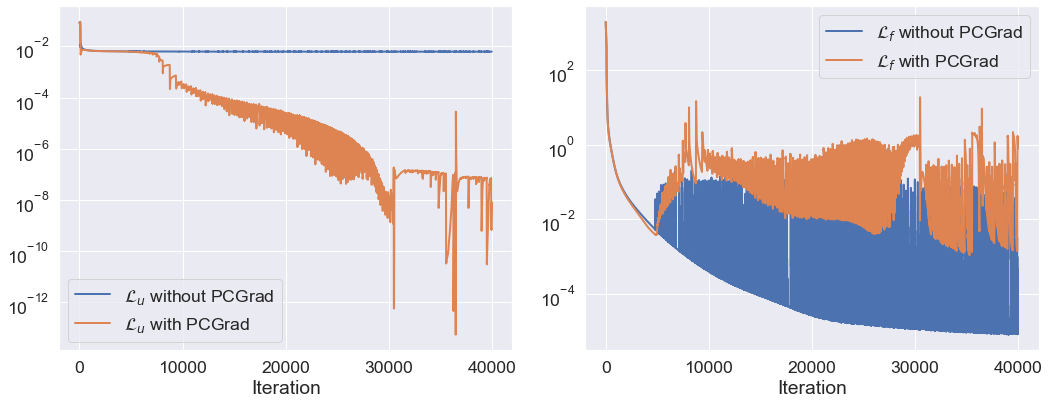

In [14]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 2, 
             label = "$\mathcal{L}_u$ without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 2, 
             label = "$\mathcal{L}_u$ with PCGrad", ax = axes[0])

axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 2, 
             label = "$\mathcal{L}_f$ without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 2, 
             label = "$\mathcal{L}_f$ with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.savefig("performance_comparison_large.pdf")

#### Solution quality comparison

In [15]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_3'] + df['state_7']
    df['system_1.5'] = df['state_4'] + df['state_6']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

In [16]:
state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [17]:
matlab_solver_solution_df = pd.read_csv('homo_example2.4.csv')
matlab_solver_solution_df.columns = ['time'] + state_column_names

In [18]:
matlab_solver_solution_df = get_system_performance(matlab_solver_solution_df)

In [19]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [20]:
matlab_solver_solution_df.head()

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,system_3.5,system_2.0,system_1.8,system_1.5,system_0
0,0.98947,0.002718,0.003901,0.003872,0.000011,0.000011,0.000016,0.000005,4.414700e-08,1.555500e-08,2.232800e-08,6.382400e-11,0.98947,0.002718,0.003917,0.003883,0.000016
1,0.97953,0.005252,0.007579,0.007458,0.000045,0.000044,0.000064,0.000023,4.313800e-07,1.523900e-07,2.192600e-07,7.835700e-10,0.97953,0.005252,0.007643,0.007502,0.000068
2,0.96988,0.007703,0.011154,0.010913,0.000089,0.000087,0.000126,0.000045,1.060200e-06,3.744100e-07,5.387400e-07,1.808400e-09,0.96988,0.007703,0.011280,0.011000,0.000136
3,0.96087,0.009961,0.014494,0.014072,0.000154,0.000150,0.000218,0.000078,2.442700e-06,8.729400e-07,1.266300e-06,1.058000e-08,0.96087,0.009961,0.014712,0.014222,0.000237
4,0.95218,0.012125,0.017716,0.017086,0.000229,0.000221,0.000323,0.000117,4.300800e-06,1.551000e-06,2.263800e-06,2.732400e-08,0.95218,0.012125,0.018039,0.017307,0.000354


#### Compare PINN solution with the solution from Matlab solver

In [21]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

######################################################################################
# Test data for validating the model predictions
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [22]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

In [23]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = state_column_names)
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = state_column_names)

In [24]:
y_pred_df = get_system_performance(y_pred_df)
y_pred_pcgrad_df = get_system_performance(y_pred_pcgrad_df)

In [25]:
sns.set_style("white")

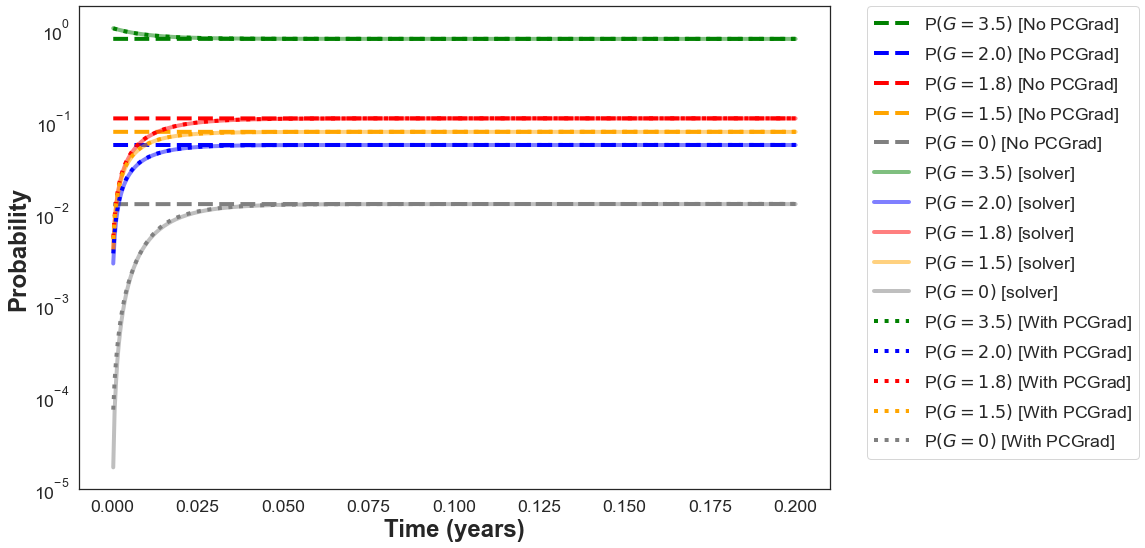

In [26]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [No PCGrad]', 
             linewidth = 4, color = 'green', linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [No PCGrad]',
             linewidth = 4, color = 'blue', linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [No PCGrad]',
             linewidth = 4, color = 'red', linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [No PCGrad]',
             linewidth = 4, color = 'orange', linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [No PCGrad]',
             linewidth = 4, color = 'gray', linestyle='--', ax=ax)


sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [solver]',
             color = 'green', alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [solver]',
             color = 'blue', alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [solver]',
             color = 'red', alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [solver]',
             color = 'orange', alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_0'], label = r'P$\left(G=0 \right)$ [solver]',
             color = 'gray', alpha=0.5, dashes=True, linewidth = 4, ax=ax)

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [With PCGrad]',
             color = 'green', linestyle='dotted', linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [With PCGrad]', 
             color = 'blue', linestyle='dotted', linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [With PCGrad]', 
             color = 'red', linestyle='dotted', linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [With PCGrad]',
             color = 'orange', linestyle='dotted', linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_0'], label = r'P$\left(G=0 \right)$ [With PCGrad]',
             color = 'gray', linestyle='dotted', linewidth = 4, ax=ax)


ax.set_yscale("log")
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=24)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=24)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("comparison_large.pdf", bbox_inches='tight')

#### Derive RMSE

In [27]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [28]:
y_diff['mse'] = y_diff.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [29]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.013387323966802
RMSE of PINN with PCGrad is 0.0004544708077466215
